In [84]:
import altair as alt
import pandas as pd

pos_1plus=[4069, 1070, 1064, 1744, 8176]
neg_1plus=[318, 85, 68, 166, 1120]

pos_2plus=[4069, 1068, 1058, 1653, 5305]
neg_2plus=[80, 24, 24, 78, 398]

pos_5plus=[4068, 1061, 1012, 1448, 2921]
neg_5plus=[5, 3, 4, 19, 77]

pos_8plus=[4068, 1041, 889, 1073, 1731]
neg_8plus=[1, 2, 1, 12, 45]

pos_10plus=[4063, 1001, 750, 796, 1242]
neg_10plus=[0, 0, 1, 0, 39]

# Sample data - replace with your actual data
data = pd.DataFrame({
    'category': ['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
    'positive_total': [4074, 1077, 1075, 1952, 17879], # BLT50 total variants for actual sites with 1+ read
    'positive_validated': pos_10plus, # BLT50 validated variants for actual sites
    'negative_total': [4074, 1077, 1075, 1952, 17879], # BLT50 total variants for +15bp sites with 1+ read (hopefully these numbers the same as ^)
    'negative_validated': neg_10plus # BLT50 validated variants for +15bp sites
})

# Create stacked data structure
data_stacked = []
for _, row in data.iterrows():
    category = row['category']
    
    # Calculate percentages for this category
    pos_validation_rate = (row['positive_validated'] / row['positive_total'] * 100) if row['positive_total'] > 0 else 0
    neg_validation_rate = (row['negative_validated'] / row['negative_total'] * 100) if row['negative_total'] > 0 else 0
    
    # Calculate unvalidated counts (difference between total and validated)
    pos_unvalidated = row['positive_total'] - row['positive_validated']
    neg_unvalidated = row['negative_total'] - row['negative_validated']
    
    # Positive side - unvalidated variants (bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_positive',
        'count': pos_unvalidated,
        'stack_order': 0,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Positive side - validated variants (stacked on top)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'validated',
        'variant_direction': 'validated_positive',
        'count': row['positive_validated'],
        'stack_order': 1,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Negative side - unvalidated variants (displayed as negative, bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_negative',
        'count': -neg_unvalidated,
        'stack_order': 0,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })
    
    # Negative side - validated variants (stacked on negative side)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'validated',
        'variant_direction': 'validated_negative',
        'count': -row['negative_validated'],
        'stack_order': 1,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })

data_long = pd.DataFrame(data_stacked)

# Create the bidirectional stacked bar chart
chart = alt.Chart(data_long).mark_bar().encode(
    x=alt.X('category:O',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            title='Categories',
            axis=alt.Axis(labelAngle=60,labelFontSize=14, titleFontSize=16)),
        y=alt.Y('count:Q',
            title='Count',
            scale=alt.Scale(domain=[-20000, 20000]), # Adjust domain as needed
            stack='zero',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelExpr="abs(datum.value)")),
    color=alt.Color('variant_direction:N',
                    scale=alt.Scale(
                        domain=['validated_positive', 'unvalidated_positive', 'validated_negative', 'unvalidated_negative'],
                        range=['#756bb1', '#9e9cad', '#a6611a', '#dfc27d']
                    ),
                    legend=alt.Legend(
                        title="Variant Type",
                        orient='right',
                        # legendX=150,
                        # legendY=700,
                        direction='vertical',
                        symbolType='square',
                        symbolSize=200,
                        titleFontSize=16,
                        labelFontSize=14,
                        labelExpr="datum.value == 'unvalidated_positive' ? 'Non-Validated' : datum.value == 'validated_positive' ? 'Validated' : datum.value == 'unvalidated_negative' ? 'Non-Validated Control' : 'Validated Control'"
                    )),
    order=alt.Order('stack_order:O'),
    tooltip=['category:O', 'direction:N', 'variant_type:N', 'count:Q', 'validation_rate:Q']
).properties(
    width=700,
    height=600,
    title=alt.TitleParams(
        text="BLT50 ALL VAF Long Read Variant Validation Counts (10+ Reads)",
        fontSize=20,
        fontWeight='bold',
        dy=-10,
        dx=100,
        anchor='start'
    )
)

# Create data for percentage labels (one per category per direction)
label_data = []
for category in data['category'].unique():
    # Positive side label
    pos_row = data[data['category'] == category].iloc[0]
    pos_validation_rate = (pos_row['positive_validated'] / pos_row['positive_total'] * 100) if pos_row['positive_total'] > 0 else 0
    pos_y_position = pos_row['positive_total']  # Top of positive stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': pos_y_position + 50,  # Slightly above the bar
        'percentage': f"{pos_validation_rate:.1f}% ({pos_row['positive_validated']}/{pos_row['positive_total']})",
        'direction': 'positive'
    })
    
    # Negative side label
    neg_validation_rate = (pos_row['negative_validated'] / pos_row['negative_total'] * 100) if pos_row['negative_total'] > 0 else 0
    neg_y_position = -pos_row['negative_total']  # Bottom of negative stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': neg_y_position - 50,  # Slightly below the bar
        'percentage': f"{neg_validation_rate:.1f}% ({pos_row['negative_validated']}/{pos_row['negative_total']})",
        'direction': 'negative'
    })

label_df = pd.DataFrame(label_data)

# Create percentage labels
percentage_labels = alt.Chart(label_df).mark_text(
    align='center',
    baseline='middle',
    fontSize=15,
    color='black',
    dy=alt.expr("datum.direction == 'positive' ? -7 : 7") 
).encode(
    x=alt.X('category:O'),
    y=alt.Y('y_position:Q'),
    text=alt.Text('percentage:N')
)

# Add a horizontal line at y=0 for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black',
    strokeWidth=1
).encode(y='y:Q')

# Create section labels for positive and negative sides - positioned independently
section_label_data = pd.DataFrame([
    {'label': 'RUFUS-Called Sites', 'y_position': 12800, 'x_pos': 0},  # Top section
    {'label': 'Control Sites +15bp', 'y_position': -4400, 'x_pos': 0}  # Bottom section
])

# Create section labels for positive and negative sides
section_labels = alt.Chart(section_label_data).mark_text(
    align='right',
    baseline='middle',
    fontSize=12,
    fontWeight='bold',
    color='#333333',
    angle=270,  # Rotate text vertically like y-axis title
    dy=-55  # Position to the left of the chart area
).encode(
    x=alt.value(0),  # Fixed x position
    y=alt.Y('y_position:Q', scale=alt.Scale(domain=[-20000, 20000])), # todo: change this domain + y-position above in section_label_data if chart height changes
    text=alt.Text('label:N')
)

# Combine all charts
final_chart = alt.layer(
    chart,
    zero_line,
    percentage_labels,
    section_labels
).resolve_scale(
    color='independent'
)

# Display the chart
final_chart.show()

# Optional: Save the chart
# final_chart.save('bidirectional_bar_chart.html')
# final_chart.save('bidirectional_bar_chart.png', scale_factor=2.0)

alt.LayerChart(...)

In [85]:
import altair as alt
import pandas as pd

# Your data arrays
pos_1plus=[4069, 1070, 1064, 1744, 8176]
neg_1plus=[318, 85, 68, 166, 1120]

pos_2plus=[4069, 1068, 1058, 1653, 5305]
neg_2plus=[80, 24, 24, 78, 398]

pos_5plus=[4068, 1061, 1012, 1448, 2921]
neg_5plus=[5, 3, 4, 19, 77]

pos_8plus=[4068, 1041, 889, 1073, 1731]
neg_8plus=[1, 2, 1, 12, 45]

pos_10plus=[4063, 1001, 750, 796, 1242]
neg_10plus=[0, 0, 1, 0, 39]

# Total counts (same for all thresholds)
pos_totals = [4074, 1077, 1075, 1952, 17879]
neg_totals = [4074, 1077, 1075, 1952, 17879]

# Pacbio only values
rufus_pos_1plus=[3790, 1607, 1057, 1069, 4069]
rufus_neg_1plus=[96, 15, 3, 5, 13]
rufus_homog_neg_1plus=[700, 92, 43, 32, 62]
rufus_pos_2plus=[3111, 1539, 1045, 1066, 4069]
rufus_neg_2plus=[35, 5, 0, 0, 0]
rufus_homog_neg_2plus=[408, 55, 26, 17, 22]
rufus_pos_5plus=[1539, 1053, 865, 1034, 4067]
rufus_neg_5plus=[20, 5, 0, 0, 0]
rufus_homog_neg_5plus=[312, 44, 19, 13, 9]
rufus_pos_8plus=[764, 506, 571, 934, 4050]
rufus_neg_8plus=[16, 5, 0, 0, 0]
rufus_homog_neg_8plus=[282, 42, 18, 13, 8]
rufus_pos_10plus=[554, 278, 398, 876, 4029]
rufus_neg_10plus=[15, 5, 0, 0, 0]
rufus_homog_neg_10plus=[268, 39, 17, 12, 8]
mutect_pos_1plus=[2479, 846, 660, 1145, 3998]
mutect_neg_1plus=[112, 7, 2, 3, 17]
mutect_homog_neg_1plus=[834, 132, 96, 72, 155]
mutect_pos_2plus=[2251, 832, 656, 1142, 3997]
mutect_neg_2plus=[68, 1, 0, 0, 3]
mutect_homog_neg_2plus=[664, 118, 87, 62, 102]
mutect_pos_5plus=[1706, 714, 626, 1134, 3995]
mutect_neg_5plus=[43, 1, 0, 0, 2]
mutect_homog_neg_5plus=[537, 96, 77, 51, 60]
mutect_pos_8plus=[1220, 534, 552, 1111, 3990]
mutect_neg_8plus=[35, 1, 0, 0, 0]
mutect_homog_neg_8plus=[467, 83, 75, 48, 51]
mutect_pos_10plus=[989, 428, 494, 1093, 3979]
mutect_neg_10plus=[31, 1, 0, 0, 0]
mutect_homog_neg_10plus=[441, 76, 72, 43, 44]

rufus_totals=[17867, 1952, 1075, 1077, 4073]
mutect_totals=[4937, 1077, 709, 1170, 4039]

categories = ['Σ C(5,1)', 'Σ C(5,2)', 'Σ C(5,3)', 'Σ C(5,4)', 'Σ C(5,5)']

# Create comprehensive dataset for line chart
trend_data = []
datasets = {
    '1+ Reads': (mutect_pos_1plus, mutect_neg_1plus),
    '2+ Reads': (mutect_pos_2plus, mutect_neg_2plus),
    '5+ Reads': (mutect_pos_5plus, mutect_neg_5plus),
    '8+ Reads': (mutect_pos_8plus, mutect_neg_8plus),
    '10+ Reads': (mutect_pos_10plus, mutect_neg_10plus)
}

for threshold, (pos_validated, neg_validated) in datasets.items():
    for i, category in enumerate(categories):
        # Positive validation percentage
        pos_rate = (pos_validated[i] / mutect_totals[i] * 100) if mutect_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': pos_rate,
            'site_type': 'RUFUS-Called',
            'line_id': f'{threshold} RUFUS-Called',
            'validated_count': pos_validated[i],
            'total_count': pos_totals[i]
        })
        
        # Negative validation percentage
        neg_rate = (neg_validated[i] / mutect_totals[i] * 100) if mutect_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': neg_rate,
            'site_type': 'Control',
            'line_id': f'{threshold} Control',
            'validated_count': neg_validated[i],
            'total_count': neg_totals[i]
        })

trend_df = pd.DataFrame(trend_data)

# Create the single line chart with all 10 lines
line_chart = alt.Chart(trend_df).mark_line(
    strokeWidth=3,
    point=alt.OverlayMarkDef(size=80, filled=True)
).encode(
    x=alt.X('category:O', 
            title='Category',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            axis=alt.Axis(labelAngle=45, labelFontSize=14, titleFontSize=16)),
    y=alt.Y('validation_rate:Q',
            title='Validation Percentage (%)',
            scale=alt.Scale(domain=[0, 100]),
            axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    color=alt.Color('threshold:N',
                    scale=alt.Scale(
                        domain=['1+ Reads', '2+ Reads', '5+ Reads', '8+ Reads', '10+ Reads'],
                        range=['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#984ea3']  # One color per threshold
                    ),
                    legend=alt.Legend(
                        title="Read Threshold",
                        titleFontSize=14,
                        labelFontSize=12,
                        orient='top-left'
                    )),
    strokeDash=alt.StrokeDash('site_type:N',
                            scale=alt.Scale(
                                domain=['Mutect2-Called', 'Control'],
                                range=[[0], [5,5]]  # Solid for RUFUS-Called, dashed for Control
                            ),
                            legend=alt.Legend(
                                title="Site Type",
                                titleFontSize=14,
                                labelFontSize=16,
                                orient='top-right',
                                symbolType='stroke',
                                symbolStrokeWidth=3,
                                values=['Mutect2-Called', 'Neg Control']
                            )),
    tooltip=['threshold:O', 'category:O', 'site_type:N', 'validation_rate:Q', 'validated_count:Q', 'total_count:Q']
).properties(
    width=800,
    height=500,
    title=alt.TitleParams(
        text="Validation Rate Trends: Mutect2-Called vs +15bp Control Sites Across Read Thresholds",
        fontSize=20,
        anchor="middle",
        fontWeight='bold',
    )
)

# Display the chart
line_chart.show()

# Optional: Save the chart
# line_chart.save('validation_trends.html')
# line_chart.save('validation_trends.png', scale_factor=2.0)

alt.Chart(...)

In [86]:
# Long read coverage plots
# Data taken from DAC website sample metadata 14Aug2025

pacbio=[35, 43, 28, 27, 22, 102, 37, 36, 33, 24]
ont=[26, 87, 38, 36, 30]

pacbio_sum=0
for i in range(len(pacbio)):
    pacbio_sum+=pacbio[i]
avg_pacbio=pacbio_sum/len(pacbio)
print(f"PacBio Average Coverage: {avg_pacbio:.1f}x")
ont_sum=0
for i in range(len(ont)):
    ont_sum+=ont[i]
avg_ont=ont_sum/len(ont)
print(f"ONT Average Coverage: {avg_ont:.1f}x")

total_sum=pacbio_sum+ont_sum
total_count=len(pacbio)+len(ont)
avg_total=total_sum/total_count
print(f"Overall Average Coverage: {avg_total:.1f}x")



PacBio Average Coverage: 38.7x
ONT Average Coverage: 43.4x
Overall Average Coverage: 40.3x


✓ Input data validation passed
Detected samples: ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']


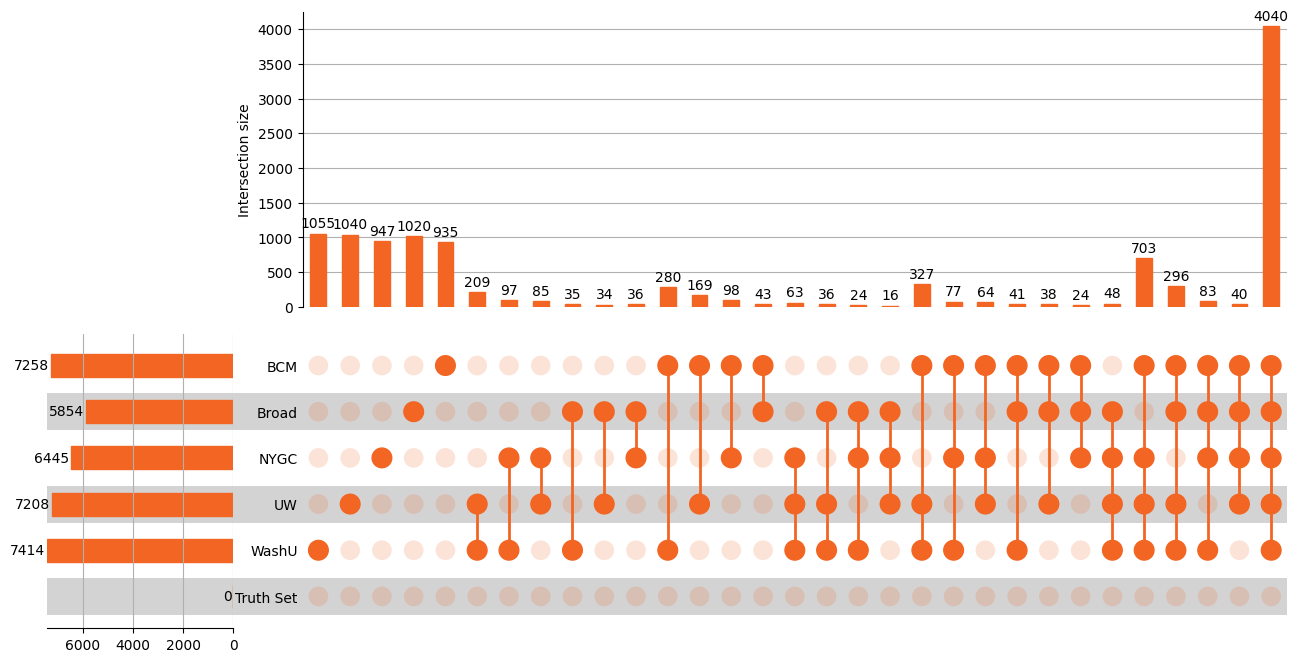

In [87]:
# Upset plots

import pandas as pd
import numpy as np
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

# Suppress pandas future warnings related to inplace operations
warnings.filterwarnings('ignore', category=FutureWarning)

def create_upset_from_intersection_counts(intersection_data, sample_names=None):
    """
    Create an UpSet plot from intersection count data.
    
    Parameters:
    -----------
    intersection_data : dict
        Dictionary where keys are intersection strings (e.g., 'A&B&C') 
        and values are counts
    sample_names : list, optional
        List of sample names. If None, will be inferred from the data.
    
    Returns:
    --------
    pandas.Series with MultiIndex for upsetplot
    """
    
    # If sample_names not provided, infer from the data
    if sample_names is None:
        all_samples = set()
        for intersection_str in intersection_data.keys():
            samples_in_intersection = intersection_str.split('&')
            all_samples.update(samples_in_intersection)
        sample_names = sorted(list(all_samples))
    
    print(f"Detected samples: {sample_names}")
    
    # Create multi-index data more explicitly to avoid pandas warnings
    index_tuples = []
    counts = []
    
    for intersection_str, count in intersection_data.items():
        # Parse which samples are in this intersection
        samples_in_intersection = set(intersection_str.split('&'))
        
        # Create boolean tuple for this intersection
        membership = tuple(sample in samples_in_intersection for sample in sample_names)
        
        index_tuples.append(membership)
        counts.append(count)
    
    # Create MultiIndex explicitly
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=sample_names
    )
    
    # Create Series with the counts - ensure it's properly formatted
    series = pd.Series(data=counts, index=multi_index, dtype=int)
    
    # Remove any zero counts to clean up the plot
    series = series[series > 0]
    
    # Sort by values (descending) to show largest intersections first
    series = series.sort_values(ascending=False)
    
    return series, sample_names

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(16, 8), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample. Can be:
        - dict: {'A': 'red', 'B': 'blue', ...}
        - list: ['red', 'blue', 'green', ...] (in order of sample_names)
        - None: uses default colors
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters (can be overridden by kwargs)
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            #'facecolor': '#756bb1',
            'facecolor': '#F26522',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 10,  # Show all intersections with at least 1 variant
            'element_size': None,  # Don't normalize - show actual counts
            'totals_plot_elements': 6  # Limit number of total elements shown
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=figsize))
        
            
            # Now customize the dot colors in the matrix plot
            # Find the intersection matrix axes
            axes = fig.get_axes()
            matrix_ax = None
            
            # The matrix plot is typically one of the lower axes
            for ax in axes:
                # Look for the axis that has scatter plots (dots)
                if hasattr(ax, 'collections') and len(ax.collections) > 0:
                    # Check if this looks like the matrix plot
                    if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                           for coll in ax.collections):
                        matrix_ax = ax
                        break
            
            if matrix_ax is not None:
                # Clear existing dots and redraw with custom colors
                matrix_ax.clear()
                
                # Get the intersection data to redraw the matrix
                intersections = []
                for idx, count in series.items():
                    intersections.append(idx)
                
                # Redraw the matrix with colored dots
                for col_idx, intersection in enumerate(intersections):
                    for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                        if is_present:
                            # Draw filled dot with sample-specific color
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c=sample_colors[sample_name], 
                                            s=100, 
                                            edgecolors='black', 
                                            linewidths=0.5,
                                            zorder=3)
                        else:
                            # Draw gray dot for non-membership
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c='lightgray', 
                                            s=30, 
                                            alpha=0.3,
                                            zorder=1)
                
                # Draw connecting lines for multi-sample intersections
                for col_idx, intersection in enumerate(intersections):
                    present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                    if len(present_rows) > 1:
                        # Draw vertical line connecting present samples
                        min_row = min(present_rows)
                        max_row = max(present_rows)
                        matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                     'black', linewidth=2, alpha=0.6, zorder=2)
                
                # Set up the matrix axes
                matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                matrix_ax.set_xticks([])
                matrix_ax.set_yticks(range(len(sample_names)))
                matrix_ax.set_yticklabels(sample_names)
                matrix_ax.invert_yaxis()
                matrix_ax.grid(True, alpha=0.3)
                
                # Remove x-axis labels as they're not needed in the matrix
                matrix_ax.set_xlabel('')
            
            # Add title with manual positioning to avoid layout issues
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Use subplots_adjust instead of tight_layout for better control
            plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add a color legend for samples only
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                             for name, color in sample_colors.items()]
            plt.figlegend(handles=legend_elements, 
                         loc='upper left', 
                         bbox_to_anchor=(0.02, 0.98),
                         title='Samples')
            
            plt.show()
            
            return upset
            
        except Exception as e:
        #     print(f"Error creating UpSet plot: {e}")
        #     print("Falling back to summary statistics...")
            
        #     # Print data summary if plot fails
        #     print(f"\nData Summary:")
        #     print(f"Series shape: {series.shape}")
        #     print(f"Series index names: {series.index.names}")
        #     print(f"Top 10 intersections:")
        #     print(series.sort_values(ascending=False).head(10))
            
             return None

def validate_intersection_data(intersection_data):
    """
    Validate the input data format and provide helpful error messages.
    """
    if not isinstance(intersection_data, dict):
        raise ValueError("intersection_data must be a dictionary")
    
    if len(intersection_data) == 0:
        raise ValueError("intersection_data cannot be empty")
    
    # Check for valid format
    for key, value in intersection_data.items():
        if not isinstance(key, str):
            raise ValueError(f"All keys must be strings, found: {type(key)}")
        
        if not isinstance(value, (int, float)):
            raise ValueError(f"All values must be numeric, found: {type(value)} for key '{key}'")
        
        if value < 0:
            raise ValueError(f"All values must be non-negative, found: {value} for key '{key}'")
        
        # Check that intersection string uses '&' separator
        if '&' not in key and len(key.split('&')) == 1:
            # Single sample - this is OK
            pass
        elif '&' in key:
            # Multiple samples - check format
            samples = key.split('&')
            if any(len(sample.strip()) == 0 for sample in samples):
                raise ValueError(f"Invalid intersection format: '{key}'. Check for empty sample names.")
    
    print("✓ Input data validation passed")
    return True

def main_example():
    rufus_isecs = {
        'BCM': 3740,
        'Broad': 220, 
        'NYGC': 577,
        'UW': 4077,
        'WashU': 9280,
        'BCM&Broad': 34,
        'BCM&NYGC': 63,
        'BCM&UW': 374, 
        'BCM&WashU': 613, 
        'Broad&NYGC': 7,
        'Broad&UW': 39,
        'Broad&WashU': 30,
        'NYGC&UW': 61,
        'NYGC&WashU': 85,
        'UW&WashU': 646,
        'BCM&Broad&NYGC': 11,
        'BCM&Broad&UW': 36,
        'BCM&Broad&WashU': 52,
        'BCM&NYGC&UW': 54,
        'BCM&NYGC&WashU': 89,
        'BCM&UW&WashU': 672,
        'Broad&NYGC&UW': 8,
        'Broad&NYGC&WashU': 15,
        'Broad&UW&WashU': 58,
        'NYGC&UW&WashU': 80,
        'BCM&Broad&NYGC&UW': 63,
        'BCM&Broad&NYGC&WashU': 58,
        'BCM&Broad&UW&WashU': 278,
        'BCM&NYGC&UW&WashU': 558,
        'Broad&NYGC&UW&WashU': 120,
        'BCM&Broad&NYGC&UW&WashU': 4074
    }

    mutect_isecs = {
        'WashU': 1055,
        'UW': 1040,
        'NYGC': 947, 
        'Broad': 1020,
        'BCM': 935,
        'UW&WashU': 209, 
        'NYGC&WashU': 97,
        'NYGC&UW': 85,
        'Broad&WashU': 35,
        'Broad&UW': 34,
        'Broad&NYGC': 36,
        'BCM&WashU': 280, 
        'BCM&UW': 169, 
        'BCM&NYGC': 98,
        'BCM&Broad': 43,
        'NYGC&UW&WashU': 63,
        'Broad&UW&WashU': 36,
        'Broad&NYGC&WashU': 24,
        'Broad&NYGC&UW': 16,
        'BCM&UW&WashU': 327,
        'BCM&NYGC&WashU': 77,
        'BCM&NYGC&UW': 64,
        'BCM&Broad&WashU': 41,
        'BCM&Broad&UW': 38,
        'BCM&Broad&NYGC': 24,
        'Broad&NYGC&UW&WashU': 48,
        'BCM&NYGC&UW&WashU': 703, 
        'BCM&Broad&UW&WashU': 296, 
        'BCM&Broad&NYGC&WashU': 83,
        'BCM&Broad&NYGC&UW': 40,
        'BCM&Broad&NYGC&UW&WashU': 4040
}
    
    # Validate input data
    validate_intersection_data(mutect_isecs)
    
    # Specify sample names explicitly (optional - will be inferred if not provided)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']
    
    # Create the UpSet plot
    series, detected_samples = create_upset_from_intersection_counts(
        mutect_isecs, sample_names
    )
    
    # print(f"\nCreated series with {len(series)} intersections")
    # print(f"Sample order: {detected_samples}")
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="All Variant Intersections Called By RUFUS In GCC Combinations Not In Truth Set",
        show_counts=True,      # Show count numbers on bars
        sort_by='degree', # Sort by intersection size
        sort_categories_by='-input'  # Sort sample categories by size
    )
    
    # Print summary
    # if series is not None:
    #     print(f"\nSummary:")
    #     print(f"Total intersections: {len(series)}")
    #     print(f"Total variants across all intersections: {series.sum()}")
    #     print(f"Largest intersection: {series.max()} variants")
    #     print(f"Smallest intersection: {series.min()} variants")
    #     print(f"Mean intersection size: {series.mean():.1f} variants")
        
    #     # Show top intersections
    #     print(f"\nTop 10 intersections by size:")
    #     top_intersections = series.sort_values(ascending=False).head(10)
    #     for idx, value in top_intersections.items():
    #         # Convert boolean tuple back to sample names
    #         samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
    #         intersection_str = '&'.join(samples_in_intersection)
    #         print(f"  {intersection_str}: {value} variants")
    
    return series, upset

if __name__ == "__main__":
    # Run the example
    series, upset = main_example()

✓ Input data validation passed
Detected samples: ['R-BCM', 'R-Broad', 'R-NYGC', 'R-UW', 'R-WashU', 'M-BCM', 'M-Broad', 'M-NYGC', 'M-UW', 'M-WashU', 'Truth Set']


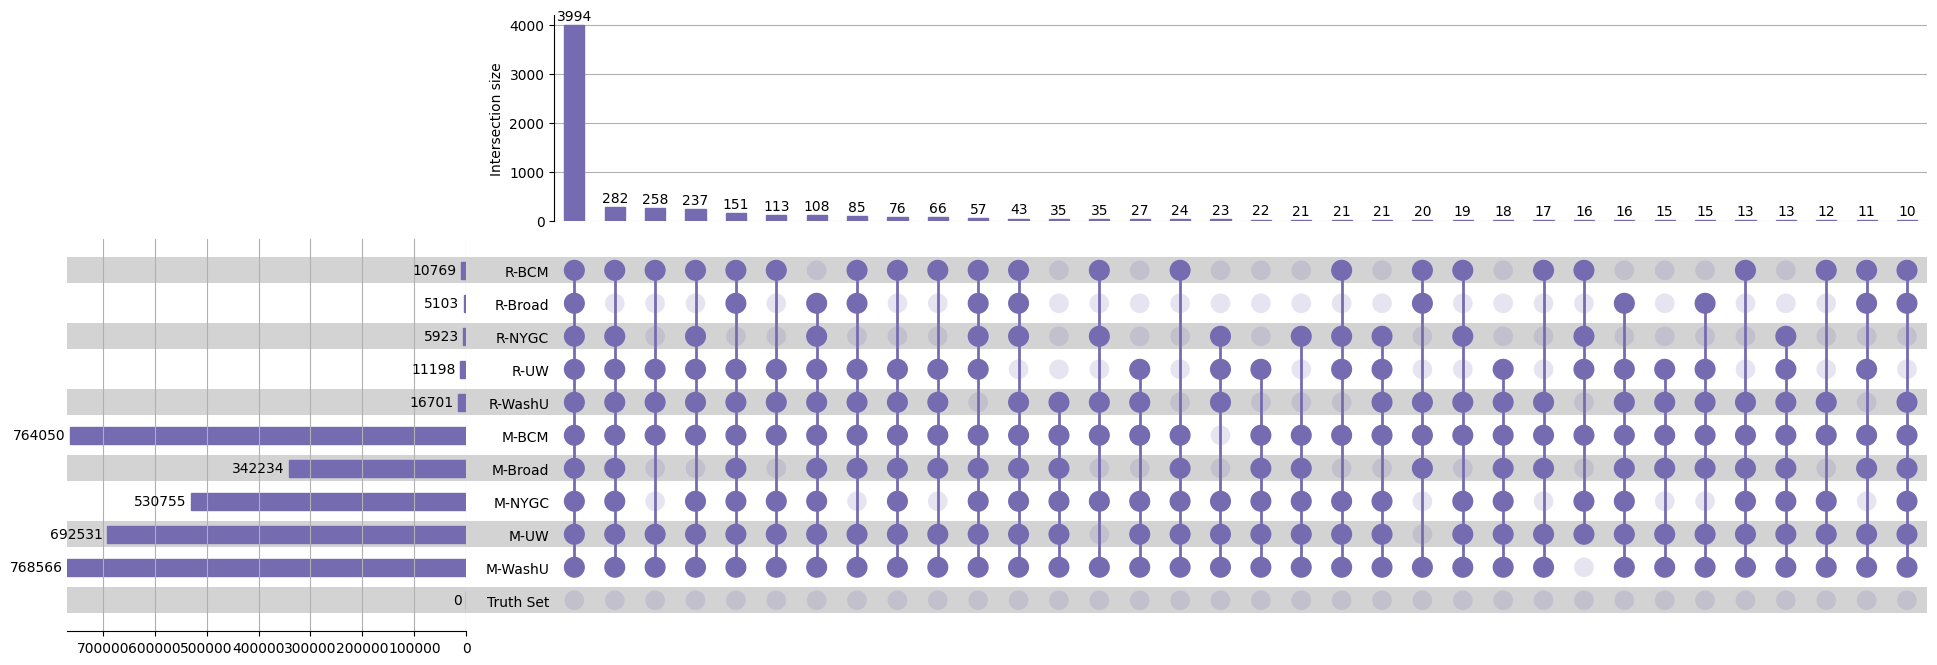

In [88]:
# Upset plots

import pandas as pd
import numpy as np
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

# Suppress pandas future warnings related to inplace operations
warnings.filterwarnings('ignore', category=FutureWarning)

def create_upset_from_intersection_counts(intersection_data, sample_names=None):
    """
    Create an UpSet plot from intersection count data.
    
    Parameters:
    -----------
    intersection_data : dict
        Dictionary where keys are intersection strings (e.g., 'A&B&C') 
        and values are counts
    sample_names : list, optional
        List of sample names. If None, will be inferred from the data.
    
    Returns:
    --------
    pandas.Series with MultiIndex for upsetplot
    """
    
    # If sample_names not provided, infer from the data
    if sample_names is None:
        all_samples = set()
        for intersection_str in intersection_data.keys():
            samples_in_intersection = intersection_str.split('&')
            all_samples.update(samples_in_intersection)
        sample_names = sorted(list(all_samples))
    
    print(f"Detected samples: {sample_names}")
    
    # Create multi-index data more explicitly to avoid pandas warnings
    index_tuples = []
    counts = []
    
    for intersection_str, count in intersection_data.items():
        # Parse which samples are in this intersection
        samples_in_intersection = set(intersection_str.split('&'))
        
        # Create boolean tuple for this intersection
        membership = tuple(sample in samples_in_intersection for sample in sample_names)
        
        index_tuples.append(membership)
        counts.append(count)
    
    # Create MultiIndex explicitly
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=sample_names
    )
    
    # Create Series with the counts - ensure it's properly formatted
    series = pd.Series(data=counts, index=multi_index, dtype=int)
    
    # Remove any zero counts to clean up the plot
    series = series[series > 0]
    
    # Sort by values (descending) to show largest intersections first
    series = series.sort_values(ascending=False)
    
    return series, sample_names

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(24, 8), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample. Can be:
        - dict: {'A': 'red', 'B': 'blue', ...}
        - list: ['red', 'blue', 'green', ...] (in order of sample_names)
        - None: uses default colors
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters (can be overridden by kwargs)
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            'facecolor': '#756bb1',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 100,  # Show all intersections with at least 1 variant
            'element_size': None,  # Don't normalize - show actual counts
            'totals_plot_elements': 10  # Limit number of total elements shown
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=figsize))
        
            
            # Now customize the dot colors in the matrix plot
            # Find the intersection matrix axes
            axes = fig.get_axes()
            matrix_ax = None
            
            # The matrix plot is typically one of the lower axes
            for ax in axes:
                # Look for the axis that has scatter plots (dots)
                if hasattr(ax, 'collections') and len(ax.collections) > 0:
                    # Check if this looks like the matrix plot
                    if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                           for coll in ax.collections):
                        matrix_ax = ax
                        break
            
            if matrix_ax is not None:
                # Clear existing dots and redraw with custom colors
                matrix_ax.clear()
                
                # Get the intersection data to redraw the matrix
                intersections = []
                for idx, count in series.items():
                    intersections.append(idx)
                
                # Redraw the matrix with colored dots
                for col_idx, intersection in enumerate(intersections):
                    for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                        if is_present:
                            # Draw filled dot with sample-specific color
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c=sample_colors[sample_name], 
                                            s=100, 
                                            edgecolors='black', 
                                            linewidths=0.5,
                                            zorder=3)
                        else:
                            # Draw gray dot for non-membership
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c='lightgray', 
                                            s=30, 
                                            alpha=0.3,
                                            zorder=1)
                
                # Draw connecting lines for multi-sample intersections
                for col_idx, intersection in enumerate(intersections):
                    present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                    if len(present_rows) > 1:
                        # Draw vertical line connecting present samples
                        min_row = min(present_rows)
                        max_row = max(present_rows)
                        matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                     'black', linewidth=2, alpha=0.6, zorder=2)
                
                # Set up the matrix axes
                matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                matrix_ax.set_xticks([])
                matrix_ax.set_yticks(range(len(sample_names)))
                matrix_ax.set_yticklabels(sample_names)
                matrix_ax.invert_yaxis()
                matrix_ax.grid(True, alpha=0.3)
                
                # Remove x-axis labels as they're not needed in the matrix
                matrix_ax.set_xlabel('')
            
            # Add title with manual positioning to avoid layout issues
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Use subplots_adjust instead of tight_layout for better control
            plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add a color legend for samples only
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                             for name, color in sample_colors.items()]
            plt.figlegend(handles=legend_elements, 
                         loc='upper left', 
                         bbox_to_anchor=(0.02, 0.98),
                         title='Samples')
            
            print("Displaying Plot...")
            plt.show()
            print("Finished displaying Plot...")

            return upset
            
        except Exception as e:
        #     print(f"Error creating UpSet plot: {e}")
        #     print("Falling back to summary statistics...")
            
        #     # Print data summary if plot fails
        #     print(f"\nData Summary:")
        #     print(f"Series shape: {series.shape}")
        #     print(f"Series index names: {series.index.names}")
        #     print(f"Top 10 intersections:")
        #     print(series.sort_values(ascending=False).head(10))
            
             return None

def validate_intersection_data(intersection_data):
    """
    Validate the input data format and provide helpful error messages.
    """
    if not isinstance(intersection_data, dict):
        raise ValueError("intersection_data must be a dictionary")
    
    if len(intersection_data) == 0:
        raise ValueError("intersection_data cannot be empty")
    
    # Check for valid format
    for key, value in intersection_data.items():
        if not isinstance(key, str):
            raise ValueError(f"All keys must be strings, found: {type(key)}")
        
        if not isinstance(value, (int, float)):
            raise ValueError(f"All values must be numeric, found: {type(value)} for key '{key}'")
        
        if value < 0:
            raise ValueError(f"All values must be non-negative, found: {value} for key '{key}'")
        
        # Check that intersection string uses '&' separator
        if '&' not in key and len(key.split('&')) == 1:
            # Single sample - this is OK
            pass
        elif '&' in key:
            # Multiple samples - check format
            samples = key.split('&')
            if any(len(sample.strip()) == 0 for sample in samples):
                raise ValueError(f"Invalid intersection format: '{key}'. Check for empty sample names.")
    
    print("✓ Input data validation passed")
    return True

def main_example():
    all_isecs = {
        'M-WashU': 207206,
        'M-UW': 163330,
        'M-NYGC': 120396,
        'M-Broad': 67849,
        'M-BCM': 206470,
        'R-WashU': 7747,
        'R-UW': 3164,
        'R-NYGC': 378,
        'R-Broad': 162,
        'R-BCM': 2812,
        'M-UW&M-WashU': 65526,
        'M-NYGC&M-WashU': 17464,
        'M-NYGC&M-UW': 17276,
        'M-Broad&M-WashU': 11272,
        'M-Broad&M-UW': 11266,
        'M-Broad&M-NYGC': 9213,
        'M-BCM&M-WashU': 60384,
        'M-BCM&M-UW': 40175,
        'M-BCM&M-NYGC': 36934,
        'M-BCM&M-Broad': 12300,
        'R-WashU&M-WashU': 742,
        'R-WashU&M-UW': 93,
        'R-WashU&M-NYGC': 29,
        'R-WashU&M-Broad': 15,
        'R-WashU&M-BCM': 63,
        'R-UW&M-WashU': 85,
        'R-UW&M-UW': 406,
        'R-UW&M-NYGC': 17,
        'R-UW&M-Broad': 4,
        'R-UW&M-BCM': 38,
        'R-UW&R-WashU': 167,
        'R-NYGC&M-WashU': 8,
        'R-NYGC&M-UW': 3,
        'R-NYGC&M-NYGC': 105,
        'R-NYGC&M-Broad': 0,
        'R-NYGC&M-BCM': 2,
        'R-NYGC&R-WashU': 12,
        'R-NYGC&R-UW': 14,
        'R-Broad&M-WashU': 0,
        'R-Broad&M-UW': 1,
        'R-Broad&M-NYGC': 0,
        'R-Broad&M-Broad': 37,
        'R-Broad&M-BCM': 0,
        'R-Broad&R-WashU': 2,
        'R-Broad&R-UW': 8,
        'R-Broad&R-NYGC': 2,
        'R-BCM&M-WashU': 44,
        'R-BCM&M-UW': 26,
        'R-BCM&M-NYGC': 18,
        'R-BCM&M-Broad': 8,
        'R-BCM&M-BCM': 512,
        'R-BCM&R-WashU': 108,
        'R-BCM&R-UW': 66,
        'R-BCM&R-NYGC': 13,
        'R-BCM&R-Broad': 3,
        'M-NYGC&M-UW&M-WashU': 17293,
        'M-Broad&M-UW&M-WashU': 13820,
        'M-Broad&M-NYGC&M-WashU': 4093,
        'M-Broad&M-NYGC&M-UW': 4340,
        'M-BCM&M-UW&M-WashU': 67658,
        'M-BCM&M-NYGC&M-WashU': 27605,
        'M-BCM&M-NYGC&M-UW': 19749,
        'M-BCM&M-Broad&M-WashU': 8518,
        'M-BCM&M-Broad&M-UW': 7382,
        'M-BCM&M-Broad&M-NYGC': 9379,
        'R-WashU&M-UW&M-WashU': 110,
        'R-WashU&M-NYGC&M-WashU': 43,
        'R-WashU&M-NYGC&M-UW': 5,
        'R-WashU&M-Broad&M-WashU': 17,
        'R-WashU&M-Broad&M-UW': 3,
        'R-WashU&M-Broad&M-NYGC': 1,
        'R-WashU&M-BCM&M-WashU': 134,
        'R-WashU&M-BCM&M-UW': 9,
        'R-WashU&M-BCM&M-NYGC': 4,
        'R-WashU&M-BCM&M-Broad': 6,
        'R-UW&M-UW&M-WashU': 66,
        'R-UW&M-NYGC&M-WashU': 7,
        'R-UW&M-NYGC&M-UW': 35,
        'R-UW&M-Broad&M-WashU': 1,
        'R-UW&M-Broad&M-UW': 19,
        'R-UW&M-Broad&M-NYGC': 2,
        'R-UW&M-BCM&M-WashU': 10,
        'R-UW&M-BCM&M-UW': 74,
        'R-UW&M-BCM&M-NYGC': 4,
        'R-UW&M-BCM&M-Broad': 1,
        'R-UW&R-WashU&M-WashU': 35,
        'R-UW&R-WashU&M-UW': 39,
        'R-UW&R-WashU&M-NYGC': 0,
        'R-UW&R-WashU&M-Broad': 3,
        'R-UW&R-WashU&M-BCM': 3,
        'R-NYGC&M-UW&M-WashU': 0,
        'R-NYGC&M-NYGC&M-WashU': 10,
        'R-NYGC&M-NYGC&M-UW': 5,
        'R-NYGC&M-Broad&M-WashU': 0,
        'R-NYGC&M-Broad&M-UW': 0,
        'R-NYGC&M-Broad&M-NYGC': 1,
        'R-NYGC&M-BCM&M-WashU': 1,
        'R-NYGC&M-BCM&M-UW': 2,
        'R-NYGC&M-BCM&M-NYGC': 15,
        'R-NYGC&M-BCM&M-Broad': 0,
        'R-NYGC&R-WashU&M-WashU': 1,
        'R-NYGC&R-WashU&M-UW': 0,
        'R-NYGC&R-WashU&M-NYGC': 10,
        'R-NYGC&R-WashU&M-Broad': 0,
        'R-NYGC&R-WashU&M-BCM': 0,
        'R-NYGC&R-UW&M-WashU': 0,
        'R-NYGC&R-UW&M-UW': 2,
        'R-NYGC&R-UW&M-NYGC': 4,
        'R-NYGC&R-UW&M-Broad': 0,
        'R-NYGC&R-UW&M-BCM': 0,
        'R-NYGC&R-UW&R-WashU': 7,
        'R-Broad&M-UW&M-WashU': 0,
        'R-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&M-NYGC&M-UW': 0,
        'R-Broad&M-Broad&M-WashU': 4,
        'R-Broad&M-Broad&M-UW': 3,
        'R-Broad&M-Broad&M-NYGC': 1,
        'R-Broad&M-BCM&M-WashU': 0,
        'R-Broad&M-BCM&M-UW': 0,
        'R-Broad&M-BCM&M-NYGC': 0,
        'R-Broad&M-BCM&M-Broad': 6,
        'R-Broad&R-WashU&M-WashU': 0,
        'R-Broad&R-WashU&M-UW': 0,
        'R-Broad&R-WashU&M-NYGC': 0,
        'R-Broad&R-WashU&M-Broad': 4,
        'R-Broad&R-WashU&M-BCM': 0,
        'R-Broad&R-UW&M-WashU': 1,
        'R-Broad&R-UW&M-UW': 2,
        'R-Broad&R-UW&M-NYGC': 0,
        'R-Broad&R-UW&M-Broad': 3,
        'R-Broad&R-UW&M-BCM': 2,
        'R-Broad&R-UW&R-WashU': 4,
        'R-Broad&R-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&M-NYGC': 0,
        'R-Broad&R-NYGC&M-Broad': 0,
        'R-Broad&R-NYGC&M-BCM': 0,
        'R-Broad&R-NYGC&R-WashU': 1,
        'R-Broad&R-NYGC&R-UW': 0,
        'R-BCM&M-UW&M-WashU': 14,
        'R-BCM&M-NYGC&M-WashU': 6,
        'R-BCM&M-NYGC&M-UW': 4,
        'R-BCM&M-Broad&M-WashU': 1,
        'R-BCM&M-Broad&M-UW': 0,
        'R-BCM&M-Broad&M-NYGC': 1,
        'R-BCM&M-BCM&M-WashU': 85,
        'R-BCM&M-BCM&M-UW': 45,
        'R-BCM&M-BCM&M-NYGC': 32,
        'R-BCM&M-BCM&M-Broad': 21,
        'R-BCM&R-WashU&M-WashU': 31,
        'R-BCM&R-WashU&M-UW': 7,
        'R-BCM&R-WashU&M-NYGC': 0,
        'R-BCM&R-WashU&M-Broad': 1,
        'R-BCM&R-WashU&M-BCM': 48,
        'R-BCM&R-UW&M-WashU': 10,
        'R-BCM&R-UW&M-UW': 22,
        'R-BCM&R-UW&M-NYGC': 2,
        'R-BCM&R-UW&M-Broad': 0,
        'R-BCM&R-UW&M-BCM': 30,
        'R-BCM&R-UW&R-WashU': 33,
        'R-BCM&R-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&M-NYGC': 1,
        'R-BCM&R-NYGC&M-Broad': 0,
        'R-BCM&R-NYGC&M-BCM': 2,
        'R-BCM&R-NYGC&R-WashU': 11,
        'R-BCM&R-NYGC&R-UW': 1,
        'R-BCM&R-Broad&M-WashU': 1,
        'R-BCM&R-Broad&M-UW': 0,
        'R-BCM&R-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&M-Broad': 1,
        'R-BCM&R-Broad&M-BCM': 0,
        'R-BCM&R-Broad&R-WashU': 2,
        'R-BCM&R-Broad&R-UW': 3,
        'R-BCM&R-Broad&R-NYGC': 1,
        'M-Broad&M-NYGC&M-UW&M-WashU': 9744,
        'M-BCM&M-NYGC&M-UW&M-WashU': 91640,
        'M-BCM&M-Broad&M-UW&M-WashU': 28117,
        'M-BCM&M-Broad&M-NYGC&M-WashU': 12134,
        'M-BCM&M-Broad&M-NYGC&M-UW': 9788,
        'R-WashU&M-NYGC&M-UW&M-WashU': 15,
        'R-WashU&M-Broad&M-UW&M-WashU': 9,
        'R-WashU&M-Broad&M-NYGC&M-WashU': 7,
        'R-WashU&M-Broad&M-NYGC&M-UW': 3,
        'R-WashU&M-BCM&M-UW&M-WashU': 80,
        'R-WashU&M-BCM&M-NYGC&M-WashU': 23,
        'R-WashU&M-BCM&M-NYGC&M-UW': 2,
        'R-WashU&M-BCM&M-Broad&M-WashU': 14,
        'R-WashU&M-BCM&M-Broad&M-UW': 2,
        'R-WashU&M-BCM&M-Broad&M-NYGC': 4,
        'R-UW&M-NYGC&M-UW&M-WashU': 12,
        'R-UW&M-Broad&M-UW&M-WashU': 10,
        'R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-UW&M-Broad&M-NYGC&M-UW': 1,
        'R-UW&M-BCM&M-UW&M-WashU': 35,
        'R-UW&M-BCM&M-NYGC&M-WashU': 5,
        'R-UW&M-BCM&M-NYGC&M-UW': 16,
        'R-UW&M-BCM&M-Broad&M-WashU': 1,
        'R-UW&M-BCM&M-Broad&M-UW': 7,
        'R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-UW&R-WashU&M-UW&M-WashU': 153,
        'R-UW&R-WashU&M-NYGC&M-WashU': 2,
        'R-UW&R-WashU&M-NYGC&M-UW': 2,
        'R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-UW&R-WashU&M-Broad&M-UW': 6,
        'R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-UW&R-WashU&M-BCM&M-WashU': 16,
        'R-UW&R-WashU&M-BCM&M-UW': 18,
        'R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-NYGC&M-NYGC&M-UW&M-WashU': 2,
        'R-NYGC&M-Broad&M-UW&M-WashU': 1,
        'R-NYGC&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&M-Broad&M-NYGC&M-UW': 0,
        'R-NYGC&M-BCM&M-UW&M-WashU': 0,
        'R-NYGC&M-BCM&M-NYGC&M-WashU': 6,
        'R-NYGC&M-BCM&M-NYGC&M-UW': 7,
        'R-NYGC&M-BCM&M-Broad&M-WashU': 0,
        'R-NYGC&M-BCM&M-Broad&M-UW': 0,
        'R-NYGC&M-BCM&M-Broad&M-NYGC': 2,
        'R-NYGC&R-WashU&M-UW&M-WashU': 0,
        'R-NYGC&R-WashU&M-NYGC&M-WashU': 21,
        'R-NYGC&R-WashU&M-NYGC&M-UW': 0,
        'R-NYGC&R-WashU&M-Broad&M-WashU': 1,
        'R-NYGC&R-WashU&M-Broad&M-UW': 0,
        'R-NYGC&R-WashU&M-Broad&M-NYGC': 0,
        'R-NYGC&R-WashU&M-BCM&M-WashU': 0,
        'R-NYGC&R-WashU&M-BCM&M-UW': 0,
        'R-NYGC&R-WashU&M-BCM&M-NYGC': 0,
        'R-NYGC&R-WashU&M-BCM&M-Broad': 0,
        'R-NYGC&R-UW&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&M-NYGC&M-UW': 15,
        'R-NYGC&R-UW&M-Broad&M-WashU': 0,
        'R-NYGC&R-UW&M-Broad&M-UW': 0,
        'R-NYGC&R-UW&M-Broad&M-NYGC': 0,
        'R-NYGC&R-UW&M-BCM&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-UW': 0,
        'R-NYGC&R-UW&M-BCM&M-NYGC': 1,
        'R-NYGC&R-UW&M-BCM&M-Broad': 0,
        'R-NYGC&R-UW&R-WashU&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-UW': 0,
        'R-NYGC&R-UW&R-WashU&M-NYGC': 2,
        'R-NYGC&R-UW&R-WashU&M-Broad': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM': 0,
        'R-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&M-BCM&M-UW&M-WashU': 1,
        'R-Broad&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&M-BCM&M-Broad&M-WashU': 1,
        'R-Broad&M-BCM&M-Broad&M-UW': 1,
        'R-Broad&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-WashU&M-UW&M-WashU': 1,
        'R-Broad&R-WashU&M-NYGC&M-WashU': 0,
        'R-Broad&R-WashU&M-NYGC&M-UW': 0,
        'R-Broad&R-WashU&M-Broad&M-WashU': 8,
        'R-Broad&R-WashU&M-Broad&M-UW': 0,
        'R-Broad&R-WashU&M-Broad&M-NYGC': 0,
        'R-Broad&R-WashU&M-BCM&M-WashU': 0,
        'R-Broad&R-WashU&M-BCM&M-UW': 0,
        'R-Broad&R-WashU&M-BCM&M-NYGC': 0,
        'R-Broad&R-WashU&M-BCM&M-Broad': 0,
        'R-Broad&R-UW&M-UW&M-WashU': 0,
        'R-Broad&R-UW&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&M-Broad&M-WashU': 0,
        'R-Broad&R-UW&M-Broad&M-UW': 11,
        'R-Broad&R-UW&M-Broad&M-NYGC': 0,
        'R-Broad&R-UW&M-BCM&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-UW': 0,
        'R-Broad&R-UW&M-BCM&M-NYGC': 0,
        'R-Broad&R-UW&M-BCM&M-Broad': 0,
        'R-Broad&R-UW&R-WashU&M-WashU': 1,
        'R-Broad&R-UW&R-WashU&M-UW': 1,
        'R-Broad&R-UW&R-WashU&M-NYGC': 0,
        'R-Broad&R-UW&R-WashU&M-Broad': 1,
        'R-Broad&R-UW&R-WashU&M-BCM': 0,
        'R-Broad&R-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&M-Broad&M-NYGC': 2,
        'R-Broad&R-NYGC&M-BCM&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-UW': 0,
        'R-Broad&R-NYGC&M-BCM&M-NYGC': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad': 0,
        'R-Broad&R-NYGC&R-WashU&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-NYGC': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM': 0,
        'R-Broad&R-NYGC&R-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU': 7,
        'R-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&M-BCM&M-UW&M-WashU': 27,
        'R-BCM&M-BCM&M-NYGC&M-WashU': 11,
        'R-BCM&M-BCM&M-NYGC&M-UW': 11,
        'R-BCM&M-BCM&M-Broad&M-WashU': 5,
        'R-BCM&M-BCM&M-Broad&M-UW': 2,
        'R-BCM&M-BCM&M-Broad&M-NYGC': 1,
        'R-BCM&R-WashU&M-UW&M-WashU': 6,
        'R-BCM&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-WashU&M-Broad&M-WashU': 1,
        'R-BCM&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-WashU&M-BCM&M-WashU': 232,
        'R-BCM&R-WashU&M-BCM&M-UW': 7,
        'R-BCM&R-WashU&M-BCM&M-NYGC': 4,
        'R-BCM&R-WashU&M-BCM&M-Broad': 2,
        'R-BCM&R-UW&M-UW&M-WashU': 3,
        'R-BCM&R-UW&M-NYGC&M-WashU': 0,
        'R-BCM&R-UW&M-NYGC&M-UW': 2,
        'R-BCM&R-UW&M-Broad&M-WashU': 0,
        'R-BCM&R-UW&M-Broad&M-UW': 0,
        'R-BCM&R-UW&M-Broad&M-NYGC': 0,
        'R-BCM&R-UW&M-BCM&M-WashU': 7,
        'R-BCM&R-UW&M-BCM&M-UW': 134,
        'R-BCM&R-UW&M-BCM&M-NYGC': 4,
        'R-BCM&R-UW&M-BCM&M-Broad': 2,
        'R-BCM&R-UW&R-WashU&M-WashU': 7,
        'R-BCM&R-UW&R-WashU&M-UW': 10,
        'R-BCM&R-UW&R-WashU&M-NYGC': 0,
        'R-BCM&R-UW&R-WashU&M-Broad': 0,
        'R-BCM&R-UW&R-WashU&M-BCM': 7,
        'R-BCM&R-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&M-Broad&M-NYGC': 0,
        'R-BCM&R-NYGC&M-BCM&M-WashU': 0,
        'R-BCM&R-NYGC&M-BCM&M-UW': 0,
        'R-BCM&R-NYGC&M-BCM&M-NYGC': 15,
        'R-BCM&R-NYGC&M-BCM&M-Broad': 0,
        'R-BCM&R-NYGC&R-WashU&M-WashU': 2,
        'R-BCM&R-NYGC&R-WashU&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-NYGC': 1,
        'R-BCM&R-NYGC&R-WashU&M-Broad': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM': 3,
        'R-BCM&R-NYGC&R-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-NYGC': 1,
        'R-BCM&R-NYGC&R-UW&M-Broad': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU': 12,
        'R-BCM&R-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&M-BCM&M-WashU': 1,
        'R-BCM&R-Broad&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&M-BCM&M-NYGC': 1,
        'R-BCM&R-Broad&M-BCM&M-Broad': 13,
        'R-BCM&R-Broad&R-WashU&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-NYGC': 2,
        'R-BCM&R-Broad&R-WashU&M-Broad': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM': 1,
        'R-BCM&R-Broad&R-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&M-Broad': 0,
        'R-BCM&R-Broad&R-UW&M-BCM': 0,
        'R-BCM&R-Broad&R-UW&R-WashU': 20,
        'R-BCM&R-Broad&R-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU': 5,
        'R-BCM&R-Broad&R-NYGC&R-UW': 1,
        'M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 117253,
        'R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 8,
        'R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 35,
        'R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 11,
        'R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 4,
        'R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 1,
        'R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 21,
        'R-UW&M-BCM&M-Broad&M-UW&M-WashU': 10,
        'R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 2,
        'R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 14,
        'R-UW&R-WashU&M-Broad&M-UW&M-WashU': 18,
        'R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-UW&R-WashU&M-BCM&M-UW&M-WashU': 99,
        'R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 4,
        'R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-UW&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-NYGC&M-Broad&M-NYGC&M-UW&M-WashU': 1,
        'R-NYGC&M-BCM&M-NYGC&M-UW&M-WashU': 6,
        'R-NYGC&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-NYGC&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-NYGC&R-WashU&M-NYGC&M-UW&M-WashU': 8,
        'R-NYGC&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-WashU&M-Broad&M-NYGC&M-WashU': 2,
        'R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-NYGC&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-NYGC&R-WashU&M-BCM&M-NYGC&M-WashU': 17,
        'R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-NYGC&R-UW&M-NYGC&M-UW&M-WashU': 2,
        'R-NYGC&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&M-Broad&M-NYGC&M-UW': 2,
        'R-NYGC&R-UW&M-BCM&M-UW&M-WashU': 1,
        'R-NYGC&R-UW&M-BCM&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-NYGC&M-UW': 7,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-UW': 0,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-NYGC&R-UW&R-WashU&M-UW&M-WashU': 1,
        'R-NYGC&R-UW&R-WashU&M-NYGC&M-WashU': 4,
        'R-NYGC&R-UW&R-WashU&M-NYGC&M-UW': 2,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-UW': 1,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC': 1,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-Broad&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&M-BCM&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-Broad&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-WashU&M-Broad&M-UW&M-WashU': 2,
        'R-Broad&R-WashU&M-Broad&M-NYGC&M-WashU': 2,
        'R-Broad&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-WashU': 6,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-UW&M-Broad&M-UW&M-WashU': 1,
        'R-Broad&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&M-BCM&M-Broad&M-WashU': 1,
        'R-Broad&R-UW&M-BCM&M-Broad&M-UW': 4,
        'R-Broad&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-UW&R-WashU&M-UW&M-WashU': 1,
        'R-Broad&R-UW&R-WashU&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&R-WashU&M-Broad&M-WashU': 2,
        'R-Broad&R-UW&R-WashU&M-Broad&M-UW': 2,
        'R-Broad&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad': 1,
        'R-Broad&R-NYGC&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-WashU&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad': 0,
        'R-Broad&R-NYGC&R-UW&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-UW': 1,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM': 0,
        'R-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&M-BCM&M-NYGC&M-UW&M-WashU': 18,
        'R-BCM&M-BCM&M-Broad&M-UW&M-WashU': 7,
        'R-BCM&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&R-WashU&M-NYGC&M-UW&M-WashU': 3,
        'R-BCM&R-WashU&M-Broad&M-UW&M-WashU': 1,
        'R-BCM&R-WashU&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-WashU&M-BCM&M-UW&M-WashU': 53,
        'R-BCM&R-WashU&M-BCM&M-NYGC&M-WashU': 31,
        'R-BCM&R-WashU&M-BCM&M-NYGC&M-UW': 2,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-WashU': 25,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-NYGC': 1,
        'R-BCM&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-UW&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-UW&M-BCM&M-UW&M-WashU': 43,
        'R-BCM&R-UW&M-BCM&M-NYGC&M-WashU': 2,
        'R-BCM&R-UW&M-BCM&M-NYGC&M-UW': 16,
        'R-BCM&R-UW&M-BCM&M-Broad&M-WashU': 1,
        'R-BCM&R-UW&M-BCM&M-Broad&M-UW': 11,
        'R-BCM&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-UW&R-WashU&M-UW&M-WashU': 15,
        'R-BCM&R-UW&R-WashU&M-NYGC&M-WashU': 1,
        'R-BCM&R-UW&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-UW&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-UW&R-WashU&M-BCM&M-WashU': 26,
        'R-BCM&R-UW&R-WashU&M-BCM&M-UW': 37,
        'R-BCM&R-UW&R-WashU&M-BCM&M-NYGC': 1,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-BCM&R-NYGC&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-BCM&M-NYGC&M-WashU': 7,
        'R-BCM&R-NYGC&M-BCM&M-NYGC&M-UW': 5,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-NYGC': 3,
        'R-BCM&R-NYGC&R-WashU&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-NYGC&M-WashU': 2,
        'R-BCM&R-NYGC&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-WashU': 4,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-NYGC': 3,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad': 0,
        'R-BCM&R-NYGC&R-UW&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-NYGC&M-UW': 1,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-NYGC': 1,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-NYGC': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-NYGC': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM': 1,
        'R-BCM&R-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-WashU': 4,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-UW': 1,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-NYGC': 3,
        'R-BCM&R-Broad&R-WashU&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-WashU': 1,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-WashU': 1,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad': 1,
        'R-BCM&R-Broad&R-UW&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad': 1,
        'R-BCM&R-Broad&R-UW&R-WashU&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM': 0,
        'R-BCM&R-Broad&R-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU': 67,
        'R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 35,
        'R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 22,
        'R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 4,
        'R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 27,
        'R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 15,
        'R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 2,
        'R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 21,
        'R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 5,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 5,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-NYGC&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 7,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-NYGC&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 23,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 1,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 1,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 2,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 2,
        'R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 8,
        'R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 1,
        'R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 1,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-WashU': 1,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW': 1,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-BCM&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 24,
        'R-BCM&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 12,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 17,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 7,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 7,
        'R-BCM&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 3,
        'R-BCM&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 4,
        'R-BCM&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 2,
        'R-BCM&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 4,
        'R-BCM&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 258,
        'R-BCM&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 4,
        'R-BCM&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 4,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 5,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-NYGC&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-BCM&M-NYGC&M-UW&M-WashU': 8,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW': 4,
        'R-BCM&R-NYGC&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-NYGC&M-WashU': 35,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-NYGC&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-NYGC&M-WashU': 2,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW': 16,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC': 1,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW': 2,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-BCM&R-Broad&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-NYGC&M-UW': 2,
        'R-BCM&R-Broad&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-WashU': 20,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-UW': 2,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-UW&M-WashU': 1,
        'R-BCM&R-Broad&R-UW&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-NYGC&M-UW': 1,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-UW': 9,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-UW&M-WashU': 2,
        'R-BCM&R-Broad&R-UW&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-WashU': 1,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad': 1,
        'R-BCM&R-Broad&R-NYGC&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC': 1,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-UW': 1,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM': 0,
        'R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 18,
        'R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 3,
        'R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 5,
        'R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 3,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 21,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 2,
        'R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 4,
        'R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 3,
        'R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 15,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 2,
        'R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 2,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 1,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 13,
        'R-BCM&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 4,
        'R-BCM&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 1,
        'R-BCM&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 113,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 66,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 4,
        'R-BCM&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 19,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 4,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 21,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 2,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 2,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 6,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 7,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 5,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 4,
        'R-BCM&R-Broad&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 9,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 3,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 11,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 4,
        'R-BCM&R-Broad&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 1,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 3,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 3,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 3,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-WashU': 1,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-UW': 1,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad': 0,
        'R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 13,
        'R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 16,
        'R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 8,
        'R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 6,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 2,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 1,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 76,
        'R-BCM&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 5,
        'R-BCM&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 8,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 237,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 1,
        'R-BCM&R-Broad&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 10,
        'R-BCM&R-Broad&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 6,
        'R-BCM&R-Broad&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 3,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 85,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 1,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 4,
        'R-BCM&R-Broad&R-NYGC&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 8,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 9,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-NYGC&M-UW&M-WashU': 1,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW': 2,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-UW&M-WashU': 1,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC': 0,
        'R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 108,
        'R-BCM&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 282,
        'R-BCM&R-Broad&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 151,
        'R-BCM&R-Broad&R-NYGC&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 43,
        'R-BCM&R-Broad&R-NYGC&R-UW&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 57,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-Broad&M-NYGC&M-UW&M-WashU': 0,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-NYGC&M-UW&M-WashU': 6,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-UW&M-WashU': 1,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-WashU': 2,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW': 3,
        'R-BCM&R-Broad&R-NYGC&R-UW&R-WashU&M-BCM&M-Broad&M-NYGC&M-UW&M-WashU': 3994

    }
    
    # Validate input data
    validate_intersection_data(all_isecs)
    
    # Specify sample names explicitly (optional - will be inferred if not provided)
    sample_names = ['R-BCM', 'R-Broad', 'R-NYGC', 'R-UW', 'R-WashU', 'M-BCM', 'M-Broad', 'M-NYGC', 'M-UW', 'M-WashU', 'Truth Set']
    
    # Create the UpSet plot
    series, detected_samples = create_upset_from_intersection_counts(
        all_isecs, sample_names
    )
    
    # print(f"\nCreated series with {len(series)} intersections")
    # print(f"Sample order: {detected_samples}")
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="All Variant Intersections Called In GCC Combinations Not In Truth Set",
        min_subset_size=10,
        min_degree=6,  # Show at least 10 intersections
        show_counts=True,      # Show count numbers on bars
        sort_by='cardinality', # Sort by intersection size
        sort_categories_by='-input'  # Sort sample categories by size
    )
    
    # Print summary
    # if series is not None:
    #     print(f"\nSummary:")
    #     print(f"Total intersections: {len(series)}")
    #     print(f"Total variants across all intersections: {series.sum()}")
    #     print(f"Largest intersection: {series.max()} variants")
    #     print(f"Smallest intersection: {series.min()} variants")
    #     print(f"Mean intersection size: {series.mean():.1f} variants")
        
    #     # Show top intersections
    #     print(f"\nTop 10 intersections by size:")
    #     top_intersections = series.sort_values(ascending=False).head(10)
    #     for idx, value in top_intersections.items():
    #         # Convert boolean tuple back to sample names
    #         samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
    #         intersection_str = '&'.join(samples_in_intersection)
    #         print(f"  {intersection_str}: {value} variants")
    
    return series, upset

if __name__ == "__main__":
    # Run the example
    series, upset = main_example()

In [89]:
# Upset plots

import pandas as pd
import numpy as np
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

# Suppress pandas future warnings related to inplace operations
warnings.filterwarnings('ignore', category=FutureWarning)

def create_upset_from_intersection_counts(intersection_data, sample_names=None):
    """
    Create an UpSet plot from intersection count data.
    
    Parameters:
    -----------
    intersection_data : dict
        Dictionary where keys are intersection strings (e.g., 'A&B&C') 
        and values are counts
    sample_names : list, optional
        List of sample names. If None, will be inferred from the data.
    
    Returns:
    --------
    pandas.Series with MultiIndex for upsetplot
    """
    
    # If sample_names not provided, infer from the data
    if sample_names is None:
        all_samples = set()
        for intersection_str in intersection_data.keys():
            samples_in_intersection = intersection_str.split('&')
            all_samples.update(samples_in_intersection)
        sample_names = sorted(list(all_samples))
    
    print(f"Detected samples: {sample_names}")
    
    # Create multi-index data more explicitly to avoid pandas warnings
    index_tuples = []
    counts = []
    
    for intersection_str, count in intersection_data.items():
        # Parse which samples are in this intersection
        samples_in_intersection = set(intersection_str.split('&'))
        
        # Create boolean tuple for this intersection
        membership = tuple(sample in samples_in_intersection for sample in sample_names)
        
        index_tuples.append(membership)
        counts.append(count)
    
    # Create MultiIndex explicitly
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=sample_names
    )
    
    # Create Series with the counts - ensure it's properly formatted
    series = pd.Series(data=counts, index=multi_index, dtype=int)
    
    # Remove any zero counts to clean up the plot
    series = series[series > 0]
    
    # Sort by values (descending) to show largest intersections first
    series = series.sort_values(ascending=False)
    
    return series, sample_names

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(16, 8), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample. Can be:
        - dict: {'A': 'red', 'B': 'blue', ...}
        - list: ['red', 'blue', 'green', ...] (in order of sample_names)
        - None: uses default colors
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters (can be overridden by kwargs)
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            #'facecolor': '#d94701',
            'facecolor': '#756bb1',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 1,  # Show all intersections with at least 1 variant
            'element_size': None,  # Don't normalize - show actual counts
            'totals_plot_elements': 6  # Limit number of total elements shown
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=figsize))
        
            
            # Now customize the dot colors in the matrix plot
            # Find the intersection matrix axes
            axes = fig.get_axes()
            matrix_ax = None
            
            # The matrix plot is typically one of the lower axes
            for ax in axes:
                # Look for the axis that has scatter plots (dots)
                if hasattr(ax, 'collections') and len(ax.collections) > 0:
                    # Check if this looks like the matrix plot
                    if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                           for coll in ax.collections):
                        matrix_ax = ax
                        break
            
            if matrix_ax is not None:
                # Clear existing dots and redraw with custom colors
                matrix_ax.clear()
                
                # Get the intersection data to redraw the matrix
                intersections = []
                for idx, count in series.items():
                    intersections.append(idx)
                
                # Redraw the matrix with colored dots
                for col_idx, intersection in enumerate(intersections):
                    for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                        if is_present:
                            # Draw filled dot with sample-specific color
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c=sample_colors[sample_name], 
                                            s=100, 
                                            edgecolors='black', 
                                            linewidths=0.5,
                                            zorder=3)
                        else:
                            # Draw gray dot for non-membership
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c='lightgray', 
                                            s=30, 
                                            alpha=0.3,
                                            zorder=1)
                
                # Draw connecting lines for multi-sample intersections
                for col_idx, intersection in enumerate(intersections):
                    present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                    if len(present_rows) > 1:
                        # Draw vertical line connecting present samples
                        min_row = min(present_rows)
                        max_row = max(present_rows)
                        matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                     'black', linewidth=2, alpha=0.6, zorder=2)
                
                # Set up the matrix axes
                matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                matrix_ax.set_xticks([])
                matrix_ax.set_yticks(range(len(sample_names)))
                matrix_ax.set_yticklabels(sample_names)
                matrix_ax.invert_yaxis()
                matrix_ax.grid(True, alpha=0.3)
                
                # Remove x-axis labels as they're not needed in the matrix
                matrix_ax.set_xlabel('')
            
            # Add title with manual positioning to avoid layout issues
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Use subplots_adjust instead of tight_layout for better control
            plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add a color legend for samples only
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                             for name, color in sample_colors.items()]
            plt.figlegend(handles=legend_elements, 
                         loc='upper left', 
                         bbox_to_anchor=(0.02, 0.98),
                         title='Samples')
            
            plt.show()
            
            return upset
            
        except Exception as e:
        #     print(f"Error creating UpSet plot: {e}")
        #     print("Falling back to summary statistics...")
            
        #     # Print data summary if plot fails
        #     print(f"\nData Summary:")
        #     print(f"Series shape: {series.shape}")
        #     print(f"Series index names: {series.index.names}")
        #     print(f"Top 10 intersections:")
        #     print(series.sort_values(ascending=False).head(10))
            
             return None

def validate_intersection_data(intersection_data):
    """
    Validate the input data format and provide helpful error messages.
    """
    if not isinstance(intersection_data, dict):
        raise ValueError("intersection_data must be a dictionary")
    
    if len(intersection_data) == 0:
        raise ValueError("intersection_data cannot be empty")
    
    # Check for valid format
    for key, value in intersection_data.items():
        if not isinstance(key, str):
            raise ValueError(f"All keys must be strings, found: {type(key)}")
        
        if not isinstance(value, (int, float)):
            raise ValueError(f"All values must be numeric, found: {type(value)} for key '{key}'")
        
        if value < 0:
            raise ValueError(f"All values must be non-negative, found: {value} for key '{key}'")
        
        # Check that intersection string uses '&' separator
        if '&' not in key and len(key.split('&')) == 1:
            # Single sample - this is OK
            pass
        elif '&' in key:
            # Multiple samples - check format
            samples = key.split('&')
            if any(len(sample.strip()) == 0 for sample in samples):
                raise ValueError(f"Invalid intersection format: '{key}'. Check for empty sample names.")
    
    print("✓ Input data validation passed")
    return True

def main_example():
    rufus_isecs = {
        'BCM': 308,
        'Broad': 30,
        'NYGC': 133,
        'UW': 283,
        'WashU': 556, 
        'BCM&Broad': 6,
        'BCM&NYGC': 13,
        'BCM&UW': 17,
        'BCM&WashU': 36,
        'Broad&NYGC': 2,
        'Broad&UW': 3,
        'Broad&WashU': 2,
        'NYGC&UW': 10,
        'NYGC&WashU': 10,
        'UW&WashU': 25,
        'BCM&Broad&NYGC': 7,
        'BCM&Broad&UW': 3,
        'BCM&Broad&WashU': 8,
        'BCM&NYGC&UW': 8,
        'BCM&NYGC&WashU': 13,
        'BCM&UW&WashU': 46,
        'Broad&NYGC&UW': 5,
        'Broad&NYGC&WashU': 8,
        'Broad&UW&WashU': 14,
        'NYGC&UW&WashU': 6,
        'BCM&Broad&NYGC&UW': 50,
        'BCM&Broad&NYGC&WashU': 38,
        'BCM&Broad&UW&WashU': 97,
        'BCM&NYGC&UW&WashU': 213,
        'Broad&NYGC&UW&WashU': 82,
        'BCM&Broad&NYGC&UW&WashU': 3578
    }

    mutect_isecs = {
        
    }
    
    # Validate input data
    validate_intersection_data(all_isecs)
    
    # Specify sample names explicitly (optional - will be inferred if not provided)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']
    
    # Create the UpSet plot
    series, detected_samples = create_upset_from_intersection_counts(
        all_isecs, sample_names
    )
    
    # print(f"\nCreated series with {len(series)} intersections")
    # print(f"Sample order: {detected_samples}")
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="Variant Intersections Called By RUFUS In GCC Combinations Not In Truth Set",
        min_subset_size=1,     # Show all intersections with at least 1 variant
        show_counts=True,      # Show count numbers on bars
        sort_by='degree', # Sort by intersection size
        sort_categories_by='-input'  # Sort sample categories by size
    )
    
    # Print summary
    # if series is not None:
    #     print(f"\nSummary:")
    #     print(f"Total intersections: {len(series)}")
    #     print(f"Total variants across all intersections: {series.sum()}")
    #     print(f"Largest intersection: {series.max()} variants")
    #     print(f"Smallest intersection: {series.min()} variants")
    #     print(f"Mean intersection size: {series.mean():.1f} variants")
        
    #     # Show top intersections
    #     print(f"\nTop 10 intersections by size:")
    #     top_intersections = series.sort_values(ascending=False).head(10)
    #     for idx, value in top_intersections.items():
    #         # Convert boolean tuple back to sample names
    #         samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
    #         intersection_str = '&'.join(samples_in_intersection)
    #         print(f"  {intersection_str}: {value} variants")
    
    return series, upset

if __name__ == "__main__":
    # Run the example
    series, upset = main_example()

NameError: name 'all_isecs' is not defined

In [ ]:
import altair as alt
import pandas as pd

# TODO: put in numbers for Mutect2 + RUFUS & adapt for 10 sets instead of 5
pos_1plus=[4069, 1070, 1064, 1744, 8176]
neg_1plus=[318, 85, 68, 166, 1120]

pos_2plus=[4069, 1068, 1058, 1653, 5305]
neg_2plus=[80, 24, 24, 78, 398]

pos_5plus=[4068, 1061, 1012, 1448, 2921]
neg_5plus=[5, 3, 4, 19, 77]

pos_8plus=[4068, 1041, 889, 1073, 1731]
neg_8plus=[1, 2, 1, 12, 45]

pos_10plus=[4063, 1001, 750, 796, 1242]
neg_10plus=[0, 0, 1, 0, 39]

# Sample data - replace with your actual data
data = pd.DataFrame({
    'category': ['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
    'positive_total': [4074, 1077, 1075, 1952, 17879], # BLT50 total variants for actual sites with 1+ read
    'positive_validated': pos_10plus, # BLT50 validated variants for actual sites
    'negative_total': [4074, 1077, 1075, 1952, 17879], # BLT50 total variants for +15bp sites with 1+ read (hopefully these numbers the same as ^)
    'negative_validated': neg_10plus # BLT50 validated variants for +15bp sites
})

# Create stacked data structure
data_stacked = []
for _, row in data.iterrows():
    category = row['category']
    
    # Calculate percentages for this category
    pos_validation_rate = (row['positive_validated'] / row['positive_total'] * 100) if row['positive_total'] > 0 else 0
    neg_validation_rate = (row['negative_validated'] / row['negative_total'] * 100) if row['negative_total'] > 0 else 0
    
    # Calculate unvalidated counts (difference between total and validated)
    pos_unvalidated = row['positive_total'] - row['positive_validated']
    neg_unvalidated = row['negative_total'] - row['negative_validated']
    
    # Positive side - unvalidated variants (bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_positive',
        'count': pos_unvalidated,
        'stack_order': 0,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Positive side - validated variants (stacked on top)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'validated',
        'variant_direction': 'validated_positive',
        'count': row['positive_validated'],
        'stack_order': 1,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Negative side - unvalidated variants (displayed as negative, bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_negative',
        'count': -neg_unvalidated,
        'stack_order': 0,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })
    
    # Negative side - validated variants (stacked on negative side)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'validated',
        'variant_direction': 'validated_negative',
        'count': -row['negative_validated'],
        'stack_order': 1,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })

data_long = pd.DataFrame(data_stacked)

# Create the bidirectional stacked bar chart
chart = alt.Chart(data_long).mark_bar().encode(
    x=alt.X('category:O',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            title='Categories',
            axis=alt.Axis(labelAngle=60,labelFontSize=14, titleFontSize=16)),
        y=alt.Y('count:Q',
            title='Count',
            scale=alt.Scale(domain=[-20000, 20000]), # Adjust domain as needed
            stack='zero',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelExpr="abs(datum.value)")),
    color=alt.Color('variant_direction:N',
                    scale=alt.Scale(
                        domain=['validated_positive', 'unvalidated_positive', 'validated_negative', 'unvalidated_negative'],
                        range=['#756bb1', '#9e9cad', '#a6611a', '#dfc27d']
                    ),
                    legend=alt.Legend(
                        title="Variant Type",
                        orient='right',
                        # legendX=150,
                        # legendY=700,
                        direction='vertical',
                        symbolType='square',
                        symbolSize=200,
                        titleFontSize=16,
                        labelFontSize=14,
                        labelExpr="datum.value == 'unvalidated_positive' ? 'Non-Validated' : datum.value == 'validated_positive' ? 'Validated' : datum.value == 'unvalidated_negative' ? 'Non-Validated Control' : 'Validated Control'"
                    )),
    order=alt.Order('stack_order:O'),
    tooltip=['category:O', 'direction:N', 'variant_type:N', 'count:Q', 'validation_rate:Q']
).properties(
    width=700,
    height=600,
    title=alt.TitleParams(
        text="BLT50 ALL VAF Long Read Variant Validation Counts (10+ Reads)",
        fontSize=20,
        fontWeight='bold',
        dy=-10,
        dx=100,
        anchor='start'
    )
)

# Create data for percentage labels (one per category per direction)
label_data = []
for category in data['category'].unique():
    # Positive side label
    pos_row = data[data['category'] == category].iloc[0]
    pos_validation_rate = (pos_row['positive_validated'] / pos_row['positive_total'] * 100) if pos_row['positive_total'] > 0 else 0
    pos_y_position = pos_row['positive_total']  # Top of positive stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': pos_y_position + 50,  # Slightly above the bar
        'percentage': f"{pos_validation_rate:.1f}% ({pos_row['positive_validated']}/{pos_row['positive_total']})",
        'direction': 'positive'
    })
    
    # Negative side label
    neg_validation_rate = (pos_row['negative_validated'] / pos_row['negative_total'] * 100) if pos_row['negative_total'] > 0 else 0
    neg_y_position = -pos_row['negative_total']  # Bottom of negative stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': neg_y_position - 50,  # Slightly below the bar
        'percentage': f"{neg_validation_rate:.1f}% ({pos_row['negative_validated']}/{pos_row['negative_total']})",
        'direction': 'negative'
    })

label_df = pd.DataFrame(label_data)

# Create percentage labels
percentage_labels = alt.Chart(label_df).mark_text(
    align='center',
    baseline='middle',
    fontSize=15,
    color='black',
    dy=alt.expr("datum.direction == 'positive' ? -7 : 7") 
).encode(
    x=alt.X('category:O'),
    y=alt.Y('y_position:Q'),
    text=alt.Text('percentage:N')
)

# Add a horizontal line at y=0 for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black',
    strokeWidth=1
).encode(y='y:Q')

# Create section labels for positive and negative sides - positioned independently
section_label_data = pd.DataFrame([
    {'label': 'RUFUS-Called Sites', 'y_position': 12800, 'x_pos': 0},  # Top section
    {'label': 'Control Sites +15bp', 'y_position': -4400, 'x_pos': 0}  # Bottom section
])

# Create section labels for positive and negative sides
section_labels = alt.Chart(section_label_data).mark_text(
    align='right',
    baseline='middle',
    fontSize=12,
    fontWeight='bold',
    color='#333333',
    angle=270,  # Rotate text vertically like y-axis title
    dy=-55  # Position to the left of the chart area
).encode(
    x=alt.value(0),  # Fixed x position
    y=alt.Y('y_position:Q', scale=alt.Scale(domain=[-20000, 20000])), # todo: change this domain + y-position above in section_label_data if chart height changes
    text=alt.Text('label:N')
)

# Combine all charts
final_chart = alt.layer(
    chart,
    zero_line,
    percentage_labels,
    section_labels
).resolve_scale(
    color='independent'
)

# Display the chart
final_chart.show()

# Optional: Save the chart
# final_chart.save('bidirectional_bar_chart.html')
# final_chart.save('bidirectional_bar_chart.png', scale_factor=2.0)

In [ ]:
import altair as alt
import pandas as pd

# Note: these only have 10 pacbio pileups, not ONT like before
rufus_pos_1plus=[3790, 1607, 1057, 1069, 4069]
rufus_neg_1plus=[96, 15, 3, 5, 13]
rufus_homog_neg_1plus=[700, 92, 43, 32, 62]
rufus_pos_2plus=[3111, 1539, 1045, 1066, 4069]
rufus_neg_2plus=[35, 5, 0, 0, 0]
rufus_homog_neg_2plus=[408, 55, 26, 17, 22]
rufus_pos_5plus=[1539, 1053, 865, 1034, 4067]
rufus_neg_5plus=[20, 5, 0, 0, 0]
rufus_homog_neg_5plus=[312, 44, 19, 13, 9]
rufus_pos_8plus=[764, 506, 571, 934, 4050]
rufus_neg_8plus=[16, 5, 0, 0, 0]
rufus_homog_neg_8plus=[282, 42, 18, 13, 8]
rufus_pos_10plus=[554, 278, 398, 876, 4029]
rufus_neg_10plus=[15, 5, 0, 0, 0]
rufus_homog_neg_10plus=[268, 39, 17, 12, 8]
mutect_pos_1plus=[2479, 846, 660, 1145, 3998]
mutect_neg_1plus=[112, 7, 2, 3, 17]
mutect_homog_neg_1plus=[834, 132, 96, 72, 155]
mutect_pos_2plus=[2251, 832, 656, 1142, 3997]
mutect_neg_2plus=[68, 1, 0, 0, 3]
mutect_homog_neg_2plus=[664, 118, 87, 62, 102]
mutect_pos_5plus=[1706, 714, 626, 1134, 3995]
mutect_neg_5plus=[43, 1, 0, 0, 2]
mutect_homog_neg_5plus=[537, 96, 77, 51, 60]
mutect_pos_8plus=[1220, 534, 552, 1111, 3990]
mutect_neg_8plus=[35, 1, 0, 0, 0]
mutect_homog_neg_8plus=[467, 83, 75, 48, 51]
mutect_pos_10plus=[989, 428, 494, 1093, 3979]
mutect_neg_10plus=[31, 1, 0, 0, 0]
mutect_homog_neg_10plus=[441, 76, 72, 43, 44]

rufus_coverage=[17867, 1952, 1075, 1077, 4073]
mutect_coverage=[4937, 1077, 709, 1170, 4039]

reads="10"
caller="Mutect2"
purple_range=['#756bb1', '#9e9cad', '#a6611a', '#dfc27d']
purple_alt=['#756bb1', '#9e9cad', '#a1841f', '#bfad6d']
green_range=['#018571', '#80cdc1', '#a6611a', '#dfc27d']
green_alt=['#018571', '#80cdc1', '#a1841f', '#bfad6d']
title="BLT50 " + caller + "-Called Variant Validation Counts (" + reads + "+ PacBio Long Reads)"
sub="Identical Negative Control Sites in ST001-1A Files (250x)"

# Sample data - replace with your actual data
data = pd.DataFrame({
    'category': ['Σ C(5,1)', 'Σ C(5,2)', 'Σ C(5,3)', 'Σ C(5,4)', 'Σ C(5,5)'],
    'positive_total': mutect_coverage, # BLT50 total variants for actual sites with 1+ read
    'positive_validated': mutect_pos_10plus, # BLT50 validated variants for actual sites
    'negative_total': mutect_coverage, # BLT50 total variants for +15bp sites with 1+ read (hopefully these numbers the same as ^)
    'negative_validated': mutect_homog_neg_10plus # BLT50 validated variants for +15bp sites
})

# Create stacked data structure
data_stacked = []
for _, row in data.iterrows():
    category = row['category']
    
    # Calculate percentages for this category
    pos_validation_rate = (row['positive_validated'] / row['positive_total'] * 100) if row['positive_total'] > 0 else 0
    neg_validation_rate = (row['negative_validated'] / row['negative_total'] * 100) if row['negative_total'] > 0 else 0
    
    # Calculate unvalidated counts (difference between total and validated)
    pos_unvalidated = row['positive_total'] - row['positive_validated']
    neg_unvalidated = row['negative_total'] - row['negative_validated']
    
    # Positive side - unvalidated variants (bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_positive',
        'count': pos_unvalidated,
        'stack_order': 0,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Positive side - validated variants (stacked on top)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'validated',
        'variant_direction': 'validated_positive',
        'count': row['positive_validated'],
        'stack_order': 1,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Negative side - unvalidated variants (displayed as negative, bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_negative',
        'count': -neg_unvalidated,
        'stack_order': 0,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })
    
    # Negative side - validated variants (stacked on negative side)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'validated',
        'variant_direction': 'validated_negative',
        'count': -row['negative_validated'],
        'stack_order': 1,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })

data_long = pd.DataFrame(data_stacked)

# Create the bidirectional stacked bar chart
chart = alt.Chart(data_long).mark_bar().encode(
    x=alt.X('category:O',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            title='Categories',
            axis=alt.Axis(labelAngle=60,labelFontSize=14, titleFontSize=16)),
        y=alt.Y('count:Q',
            title='Count',
            scale=alt.Scale(domain=[-5000, 5000]), # Adjust domain as needed
            stack='zero',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelExpr="abs(datum.value)")),
    color=alt.Color('variant_direction:N',
                    scale=alt.Scale(
                        domain=['validated_positive', 'unvalidated_positive', 'validated_negative', 'unvalidated_negative'],
                        range=green_alt
                    ),
                    legend=alt.Legend(
                        title="Variant Type",
                        orient='right',
                        # legendX=150,
                        # legendY=700,
                        direction='vertical',
                        symbolType='square',
                        symbolSize=200,
                        titleFontSize=16,
                        labelFontSize=14,
                        labelExpr="datum.value == 'unvalidated_positive' ? 'Non-Validated' : datum.value == 'validated_positive' ? 'Validated' : datum.value == 'unvalidated_negative' ? 'Non-Validated Control' : 'Validated Control'"
                    )),
    order=alt.Order('stack_order:O'),
    tooltip=['category:O', 'direction:N', 'variant_type:N', 'count:Q', 'validation_rate:Q']
).properties(
    width=700,
    height=600,
    title=alt.TitleParams(
        text=title,
        subtitle=sub,
        fontSize=20,
        fontWeight='bold',
        subtitleFontSize=16,
        dy=-10,
        dx=100,
        anchor='start'
    )
)

# Create data for percentage labels (one per category per direction)
label_data = []
for category in data['category'].unique():
    # Positive side label
    pos_row = data[data['category'] == category].iloc[0]
    pos_validation_rate = (pos_row['positive_validated'] / pos_row['positive_total'] * 100) if pos_row['positive_total'] > 0 else 0
    pos_y_position = pos_row['positive_total']  # Top of positive stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': pos_y_position + 50,  # Slightly above the bar
        'percentage': f"{pos_validation_rate:.1f}% ({pos_row['positive_validated']}/{pos_row['positive_total']})",
        'direction': 'positive'
    })
    
    # Negative side label
    neg_validation_rate = (pos_row['negative_validated'] / pos_row['negative_total'] * 100) if pos_row['negative_total'] > 0 else 0
    neg_y_position = -pos_row['negative_total']  # Bottom of negative stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': neg_y_position - 50,  # Slightly below the bar
        'percentage': f"{neg_validation_rate:.1f}% ({pos_row['negative_validated']}/{pos_row['negative_total']})",
        'direction': 'negative'
    })

label_df = pd.DataFrame(label_data)

# Create percentage labels
percentage_labels = alt.Chart(label_df).mark_text(
    align='center',
    baseline='middle',
    fontSize=15,
    color='black',
    dy=alt.expr("datum.direction == 'positive' ? -7 : 7") 
).encode(
    x=alt.X('category:O'),
    y=alt.Y('y_position:Q'),
    text=alt.Text('percentage:N')
)

# Add a horizontal line at y=0 for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black',
    strokeWidth=1
).encode(y='y:Q')

# Create section labels for positive and negative sides - positioned independently
section_label_data = pd.DataFrame([
    {'label': 'Mutect2-Called Sites', 'y_position': 4800, 'x_pos': 0},  # Top section
    {'label': 'Control Sites +15bp', 'y_position': -2400, 'x_pos': 0}  # Bottom section
])

# Create section labels for positive and negative sides
section_labels = alt.Chart(section_label_data).mark_text(
    align='right',
    baseline='middle',
    fontSize=12,
    fontWeight='bold',
    color='#333333',
    angle=270,  # Rotate text vertically like y-axis title
    dy=-55  # Position to the left of the chart area
).encode(
    x=alt.value(0),  # Fixed x position
    y=alt.Y('y_position:Q', scale=alt.Scale(domain=[-5000, 5000])), # todo: change this domain + y-position above in section_label_data if chart height changes
    text=alt.Text('label:N')
)

# Combine all charts
final_chart = alt.layer(
    chart,
    zero_line,
    percentage_labels,
    section_labels
).resolve_scale(
    color='independent'
)

# Display the chart
final_chart.show()

# Optional: Save the chart
# final_chart.save('bidirectional_bar_chart.html')
# final_chart.save('bidirectional_bar_chart.png', scale_factor=2.0)

✓ Input data validation passed
Detected samples: ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']
Found bar chart axis with 31 bars
Current labels: ['−5', '0', '5', '10', '15']...
Applied 30° rotation to x-axis labels


/var/folders/gq/tmwqn0b1225dz42d9gps_lqr0000gn/T/ipykernel_50075/3860406204.py:395: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_chart_ax.set_xticklabels(current_labels,


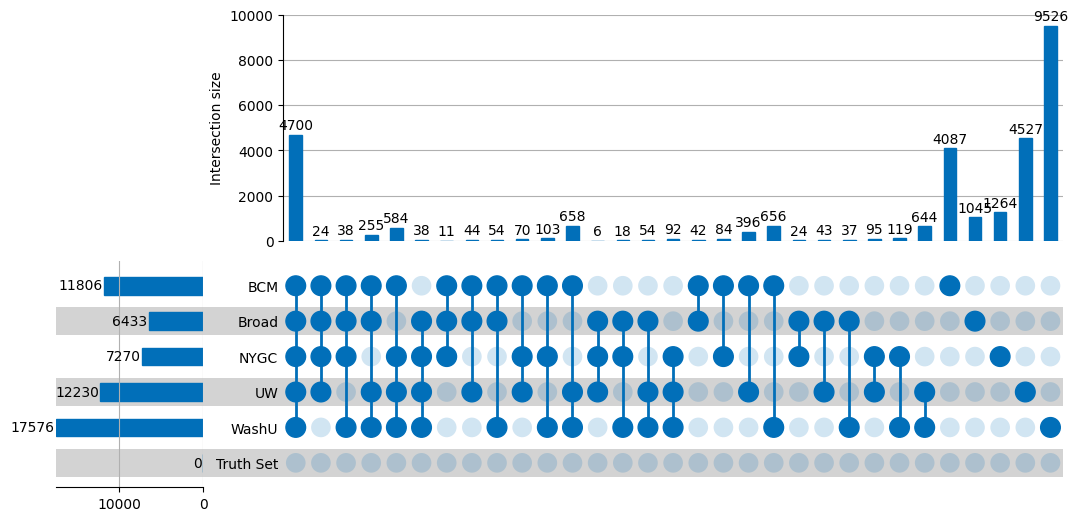

In [18]:
# RUFUS/Mutect2 Upset Plot

union_isecs={
'WashU': 9526,
'UW': 4527,
'NYGC': 1264,
'Broad': 1045,
'BCM': 4087,
'UW&WashU': 644,
'NYGC&WashU': 119, 
'NYGC&UW': 95,
'Broad&WashU': 37,
'Broad&UW': 43,
'Broad&NYGC': 24,
'BCM&WashU': 656,
'BCM&UW': 396,
'BCM&NYGC': 84,
'BCM&Broad': 42,
'NYGC&UW&WashU': 92,
'Broad&UW&WashU': 54,
'Broad&NYGC&WashU': 18,
'Broad&NYGC&UW': 6,
'BCM&UW&WashU': 658, 
'BCM&NYGC&WashU': 103, 
'BCM&NYGC&UW': 70,
'BCM&Broad&WashU': 54,
'BCM&Broad&UW': 44,
'BCM&Broad&NYGC': 11,
'Broad&NYGC&UW&WashU': 38,
'BCM&NYGC&UW&WashU': 584,
'BCM&Broad&UW&WashU': 255, 
'BCM&Broad&NYGC&WashU': 38,
'BCM&Broad&NYGC&UW': 24,
'BCM&Broad&NYGC&UW&WashU': 4700
}

# Upset plots

import pandas as pd
import numpy as np
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

# Suppress pandas future warnings related to inplace operations
warnings.filterwarnings('ignore', category=FutureWarning)

def create_upset_from_intersection_counts(intersection_data, sample_names=None):
    """
    Create an UpSet plot from intersection count data.
    
    Parameters:
    -----------
    intersection_data : dict
        Dictionary where keys are intersection strings (e.g., 'A&B&C') 
        and values are counts
    sample_names : list, optional
        List of sample names. If None, will be inferred from the data.
    
    Returns:
    --------
    pandas.Series with MultiIndex for upsetplot
    """
    
    # If sample_names not provided, infer from the data
    if sample_names is None:
        all_samples = set()
        for intersection_str in intersection_data.keys():
            samples_in_intersection = intersection_str.split('&')
            all_samples.update(samples_in_intersection)
        sample_names = sorted(list(all_samples))
    
    print(f"Detected samples: {sample_names}")
    
    # Create multi-index data more explicitly to avoid pandas warnings
    index_tuples = []
    counts = []
    
    for intersection_str, count in intersection_data.items():
        # Parse which samples are in this intersection
        samples_in_intersection = set(intersection_str.split('&'))
        
        # Create boolean tuple for this intersection
        membership = tuple(sample in samples_in_intersection for sample in sample_names)
        
        index_tuples.append(membership)
        counts.append(count)
    
    # Create MultiIndex explicitly
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=sample_names
    )
    
    # Create Series with the counts - ensure it's properly formatted
    series = pd.Series(data=counts, index=multi_index, dtype=int)
    
    # Remove any zero counts to clean up the plot
    series = series[series > 0]
    
    # Sort by values (descending) to show largest intersections first
    series = series.sort_values(ascending=False)
    
    return series, sample_names

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(20, 10), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample. Can be:
        - dict: {'A': 'red', 'B': 'blue', ...}
        - list: ['red', 'blue', 'green', ...] (in order of sample_names)
        - None: uses default colors
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters (can be overridden by kwargs)
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            #'facecolor': '#d94701',
            'facecolor': '#016FB9',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 1,  # Show all intersections with at least 1 variant
            'element_size': None,  
            'totals_plot_elements': 6  # Limit number of total elements shown
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=(13,7.5)))

            
            # Now customize the dot colors in the matrix plot
            # Find the intersection matrix axes
            axes = fig.get_axes()
            matrix_ax = None
            
            # The matrix plot is typically one of the lower axes
            for ax in axes:
                # Look for the axis that has scatter plots (dots)
                if hasattr(ax, 'collections') and len(ax.collections) > 0:
                    # Check if this looks like the matrix plot
                    if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                           for coll in ax.collections):
                        matrix_ax = ax
                        break
            
            if matrix_ax is not None:
                # Clear existing dots and redraw with custom colors
                matrix_ax.clear()
                
                # Get the intersection data to redraw the matrix
                intersections = []
                for idx, count in series.items():
                    intersections.append(idx)
                
                # Redraw the matrix with colored dots
                for col_idx, intersection in enumerate(intersections):
                    for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                        if is_present:
                            # Draw filled dot with sample-specific color
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c=sample_colors[sample_name], 
                                            s=100, 
                                            edgecolors='black', 
                                            linewidths=0.5,
                                            zorder=3)
                        else:
                            # Draw gray dot for non-membership
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c='lightgray', 
                                            s=30, 
                                            alpha=0.3,
                                            zorder=1)
                
                # Draw connecting lines for multi-sample intersections
                for col_idx, intersection in enumerate(intersections):
                    present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                    if len(present_rows) > 1:
                        # Draw vertical line connecting present samples
                        min_row = min(present_rows)
                        max_row = max(present_rows)
                        matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                     'black', linewidth=2, alpha=0.6, zorder=2)
                
                # Set up the matrix axes
                matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                matrix_ax.set_xticks([])
                matrix_ax.set_yticks(range(len(sample_names)))
                matrix_ax.set_yticklabels(sample_names)
                matrix_ax.invert_yaxis()
                matrix_ax.grid(True, alpha=0.3)
                
                # Remove x-axis labels as they're not needed in the matrix
                matrix_ax.set_xlabel('')
            
            # Add title with manual positioning to avoid layout issues
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Use subplots_adjust instead of tight_layout for better control
            plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add a color legend for samples only
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                             for name, color in sample_colors.items()]
            plt.figlegend(handles=legend_elements, 
                         loc='upper left', 
                         bbox_to_anchor=(0.02, 0.98),
                         title='Samples')
            
            plt.show()
            
            return upset
            
        except Exception as e:
        #     print(f"Error creating UpSet plot: {e}")
        #     print("Falling back to summary statistics...")
            
        #     # Print data summary if plot fails
        #     print(f"\nData Summary:")
        #     print(f"Series shape: {series.shape}")
        #     print(f"Series index names: {series.index.names}")
        #     print(f"Top 10 intersections:")
        #     print(series.sort_values(ascending=False).head(10))
            
             return None

def validate_intersection_data(intersection_data):
    """
    Validate the input data format and provide helpful error messages.
    """
    if not isinstance(intersection_data, dict):
        raise ValueError("intersection_data must be a dictionary")
    
    if len(intersection_data) == 0:
        raise ValueError("intersection_data cannot be empty")
    
    # Check for valid format
    for key, value in intersection_data.items():
        if not isinstance(key, str):
            raise ValueError(f"All keys must be strings, found: {type(key)}")
        
        if not isinstance(value, (int, float)):
            raise ValueError(f"All values must be numeric, found: {type(value)} for key '{key}'")
        
        if value < 0:
            raise ValueError(f"All values must be non-negative, found: {value} for key '{key}'")
        
        # Check that intersection string uses '&' separator
        if '&' not in key and len(key.split('&')) == 1:
            # Single sample - this is OK
            pass
        elif '&' in key:
            # Multiple samples - check format
            samples = key.split('&')
            if any(len(sample.strip()) == 0 for sample in samples):
                raise ValueError(f"Invalid intersection format: '{key}'. Check for empty sample names.")
    
    print("✓ Input data validation passed")
    return True

def angle_upset_labels(fig, angle=30):
    """
    Post-process an existing UpSet plot to angle the bar chart labels.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure containing the UpSet plot
    angle : float
        Rotation angle in degrees
    """
    axes = fig.get_axes()
    
    # Find the bar chart axis
    for ax in axes:
        if hasattr(ax, 'patches') and len(ax.patches) > 0:
            # Check if this has Rectangle patches (bars)
            if any(hasattr(patch, 'get_width') for patch in ax.patches):
                # This is likely the bar chart
                labels = ax.get_xticklabels()
                ax.set_xticklabels(labels, 
                                 rotation=angle, 
                                 ha='right',
                                 va='top')
                # Adjust bottom margin
                fig.subplots_adjust(bottom=0.2)
                break
    
    return fig


def main_example():
    
    
    # Validate input data
    validate_intersection_data(union_isecs)
    
    # Specify sample names explicitly (optional - will be inferred if not provided)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']
    
    # Create the UpSet plot
    series, detected_samples = create_upset_from_intersection_counts(
        union_isecs, sample_names
    )
    
    # print(f"\nCreated series with {len(series)} intersections")
    # print(f"Sample order: {detected_samples}")
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="Variant Intersections Called By RUFUS In GCC Combinations Not In Truth Set",
        min_subset_size=1,     # Show all intersections with at least 1 variant
        show_counts=True,      # Show count numbers on bars
        sort_by='-degree', # Sort by intersection size
        sort_categories_by='-input'  # Sort sample categories by size
    )
    
    # Print summary
    # if series is not None:
    #     print(f"\nSummary:")
    #     print(f"Total intersections: {len(series)}")
    #     print(f"Total variants across all intersections: {series.sum()}")
    #     print(f"Largest intersection: {series.max()} variants")
    #     print(f"Smallest intersection: {series.min()} variants")
    #     print(f"Mean intersection size: {series.mean():.1f} variants")
        
    #     # Show top intersections
    #     print(f"\nTop 10 intersections by size:")
    #     top_intersections = series.sort_values(ascending=False).head(10)
    #     for idx, value in top_intersections.items():
    #         # Convert boolean tuple back to sample names
    #         samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
    #         intersection_str = '&'.join(samples_in_intersection)
    #         print(f"  {intersection_str}: {value} variants")
    
    return series, upset

def angle_upset_labels(fig, angle=30):
    """
    Post-process an existing UpSet plot to angle the bar chart labels.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure containing the UpSet plot
    angle : float
        Rotation angle in degrees
    """
    axes = fig.get_axes()
    
    # Find the bar chart axis - it's usually the one with the most patches (bars)
    bar_chart_ax = None
    max_patches = 0
    
    for ax in axes:
        if hasattr(ax, 'patches') and len(ax.patches) > 0:
            # Count rectangle patches (bars)
            rect_patches = [p for p in ax.patches if hasattr(p, 'get_width') and hasattr(p, 'get_height')]
            if len(rect_patches) > max_patches:
                max_patches = len(rect_patches)
                bar_chart_ax = ax
    
    if bar_chart_ax is not None:
        print(f"Found bar chart axis with {max_patches} bars")
        
        # Get current tick locations and labels
        tick_locs = bar_chart_ax.get_xticks()
        current_labels = [label.get_text() for label in bar_chart_ax.get_xticklabels()]
        
        print(f"Current labels: {current_labels[:5]}...")  # Show first 5 for debugging
        
        # Apply rotation to labels
        bar_chart_ax.set_xticklabels(current_labels, 
                                   rotation=angle, 
                                   ha='right',
                                   va='top')
        
        # Adjust bottom margin to accommodate angled labels
        fig.subplots_adjust(bottom=0.25)
        print(f"Applied {angle}° rotation to x-axis labels")
    else:
        print("Could not find bar chart axis")
        # Debug: print info about all axes
        for i, ax in enumerate(axes):
            print(f"Axis {i}: {len(ax.patches)} patches, {len(ax.get_xticklabels())} x-labels")
    
    return fig

if __name__ == "__main__":
    # Run the example
    series, upset = main_example()
    angle_upset_labels(plt.gcf(), angle=30)

✓ Input data validation passed
Detected samples: ['BCM', 'Broad', 'NYGC', 'UW', 'WashU']
Error creating UpSet plot: 'dict' object has no attribute 'get_axes'
Found 4 axes in the figure
Axis 0: area=0.256, 5 patches, pos=(0.125, 0.110)
Axis 1: area=0.203, 0 patches, pos=(0.285, 0.110)
Axis 2: area=0.038, 5 patches, pos=(0.125, 0.110)
Axis 3: area=0.248, 31 patches, pos=(0.285, 0.477)
  -> New candidate for main bar chart
Working with main bar chart axis (area: 0.248)
Found 31 text annotations
Rotated text 0: '4700' at position (np.float64(-0.3), array([4800.023]))
Rotated text 1: '24' at position (np.float64(0.7), array([124.023]))
Rotated text 2: '38' at position (np.float64(1.7), array([138.023]))
Rotated text 3: '255' at position (np.float64(2.7), array([355.023]))
Rotated text 4: '584' at position (np.float64(3.7), array([684.023]))
Rotated text 5: '38' at position (np.float64(4.7), array([138.023]))
Rotated text 6: '11' at position (np.float64(5.7), array([111.023]))
Rotated text 7

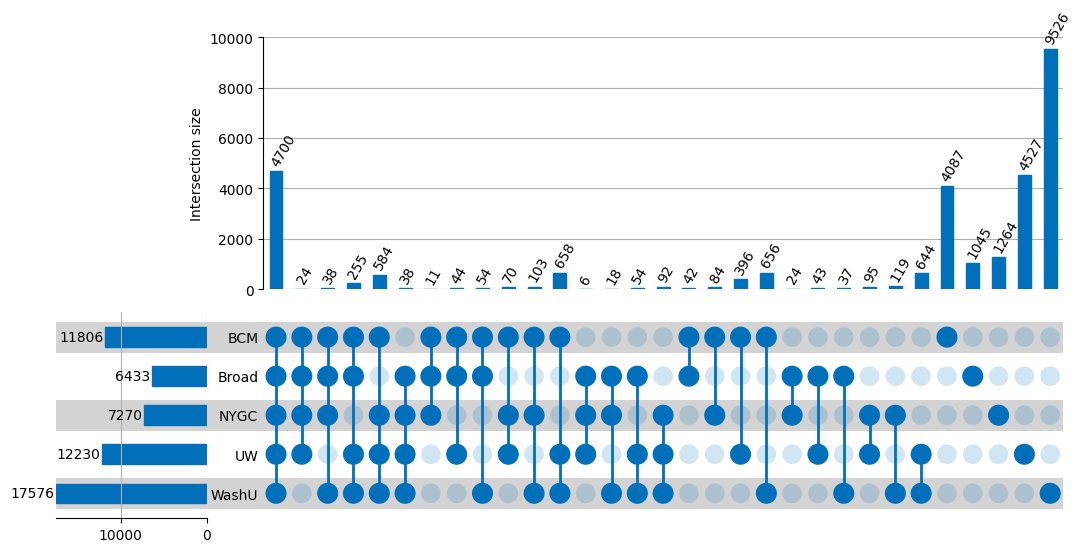

In [47]:
# Modified plot_upset function with angled labels

# Modified plot_upset function with angled labels

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(20, 10), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot with angled labels.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            'facecolor': '#016FB9',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 1,
            'element_size': None,  
            'totals_plot_elements': 6
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=(13,6.5)))
            
            # Find the bar chart axis and angle the labels
            axes = fig.get_axes()
            
            # The bar chart is typically the largest axis or the one with bars
            bar_chart_ax = None
            matrix_ax = None
            
            for ax in axes:
                # Look for the bar chart (has Rectangle patches)
                if hasattr(ax, 'patches') and len(ax.patches) > 0:
                    # Check if this has Rectangle patches (bars)
                    if any(hasattr(patch, 'get_width') for patch in ax.patches):
                        bar_chart_ax = ax
                        break
            
            # Angle the x-axis labels on the bar chart
            if bar_chart_ax is not None:
                # Get current labels
                labels = bar_chart_ax.get_xticklabels()
                
                # If there are no labels, create them based on intersection names
                if not labels or all(label.get_text() == '' for label in labels):
                    # Create custom labels based on the intersection data
                    intersection_labels = []
                    for idx, count in series.items():
                        # Convert boolean tuple back to sample names
                        samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
                        intersection_str = ' & '.join(samples_in_intersection)
                        intersection_labels.append(intersection_str)
                    
                    # Set new labels with rotation
                    bar_chart_ax.set_xticks(range(len(intersection_labels)))
                    bar_chart_ax.set_xticklabels(intersection_labels, 
                                                rotation=30, 
                                                ha='right',  # horizontal alignment
                                                va='top')   # vertical alignment
                else:
                    # Rotate existing labels
                    bar_chart_ax.set_xticklabels(labels, 
                                                rotation=30, 
                                                ha='right',
                                                va='top')
                
                # Adjust margins to accommodate angled labels
                plt.subplots_adjust(bottom=0.2)
            
            # Handle matrix customization if sample_colors provided
            if sample_colors:
                # Find the intersection matrix axes
                for ax in axes:
                    if hasattr(ax, 'collections') and len(ax.collections) > 0:
                        if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                               for coll in ax.collections):
                            matrix_ax = ax
                            break
                
                if matrix_ax is not None:
                    # Clear existing dots and redraw with custom colors
                    matrix_ax.clear()
                    
                    # Get the intersection data to redraw the matrix
                    intersections = []
                    for idx, count in series.items():
                        intersections.append(idx)
                    
                    # Redraw the matrix with colored dots
                    for col_idx, intersection in enumerate(intersections):
                        for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                            if is_present:
                                matrix_ax.scatter(col_idx, row_idx, 
                                                c=sample_colors[sample_name], 
                                                s=100, 
                                                edgecolors='black', 
                                                linewidths=0.5,
                                                zorder=3)
                            else:
                                matrix_ax.scatter(col_idx, row_idx, 
                                                c='lightgray', 
                                                s=30, 
                                                alpha=0.3,
                                                zorder=1)
                    
                    # Draw connecting lines
                    for col_idx, intersection in enumerate(intersections):
                        present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                        if len(present_rows) > 1:
                            min_row = min(present_rows)
                            max_row = max(present_rows)
                            matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                         'black', linewidth=2, alpha=0.6, zorder=2)
                    
                    # Set up the matrix axes
                    matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                    matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                    matrix_ax.set_xticks([])
                    matrix_ax.set_yticks(range(len(sample_names)))
                    matrix_ax.set_yticklabels(sample_names)
                    matrix_ax.invert_yaxis()
                    matrix_ax.grid(True, alpha=0.3)
                    matrix_ax.set_xlabel('')
            
            # Add title
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Adjust layout with extra bottom space for angled labels
            plt.subplots_adjust(top=0.92, bottom=0.2, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add color legend if sample_colors provided
            if sample_colors:
                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                                 for name, color in sample_colors.items()]
                plt.figlegend(handles=legend_elements, 
                             loc='upper left', 
                             bbox_to_anchor=(0.02, 0.98),
                             title='Samples')
            
            plt.show()
            return upset
            
        except Exception as e:
            print(f"Error creating UpSet plot: {e}")
            return None

# Alternative approach: Post-processing function to angle labels after plot creation
def angle_upset_labels(fig, angle=90):
    """
    Post-process an existing UpSet plot to angle the labels above the vertical bars.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure containing the UpSet plot
    angle : float
        Rotation angle in degrees
    """
    axes = fig.get_axes()
    print(f"Found {len(axes)} axes in the figure")
    
    # Find the main bar chart axis (vertical bars showing intersection sizes)
    # This is typically the largest axis and has vertical bars
    main_bar_ax = None
    max_area = 0
    
    for i, ax in enumerate(axes):
        bbox = ax.get_position()
        area = bbox.width * bbox.height
        patches_count = len(ax.patches) if hasattr(ax, 'patches') else 0
        
        print(f"Axis {i}: area={area:.3f}, {patches_count} patches, pos=({bbox.x0:.3f}, {bbox.y0:.3f})")
        
        # The main plot is usually the largest and has many patches (bars)
        if area > max_area and patches_count > 5:  # Should have multiple bars
            max_area = area
            main_bar_ax = ax
            print(f"  -> New candidate for main bar chart")
    
    if main_bar_ax is not None:
        print(f"Working with main bar chart axis (area: {max_area:.3f})")
        
        # Check if this axis has text annotations (the numbers above bars)
        texts = main_bar_ax.texts
        print(f"Found {len(texts)} text annotations")
        
        # Rotate the text annotations (numbers above bars)
        for i, text in enumerate(texts):
            current_text = text.get_text()
            if current_text.strip():  # Only rotate non-empty text
                text.set_rotation(angle)
                text.set_ha('left')   # Changed from 'right' to 'left' for better positioning
                text.set_va('bottom')  # Keep vertical alignment at bottom
                
                # Adjust horizontal position slightly to center better over bars
                current_pos = text.get_position()
                # Shift slightly right (adjust the 0.05 value if needed)
                text.set_position((current_pos[0] - 0.3, current_pos[1]))
                
                print(f"Rotated text {i}: '{current_text}' at position {text.get_position()}")
        
        # Adjust top margin to accommodate angled labels
        fig.subplots_adjust(top=0.85)
        print(f"Applied {angle}° rotation to {len(texts)} text labels")
        
    else:
        print("Could not find main bar chart axis")
        # Fallback: try to find any axis with text annotations
        for i, ax in enumerate(axes):
            if ax.texts:
                print(f"Fallback: rotating texts on axis {i}")
                for text in ax.texts:
                    if text.get_text().strip():
                        text.set_rotation(angle)
                        text.set_ha('left')
                        text.set_va('bottom')
                        # Apply same position adjustment
                        current_pos = text.get_position()
                        text.set_position((current_pos[0] - 0.3, current_pos[1]))
                fig.subplots_adjust(top=0.85)
                break
    
    # Force a redraw
    fig.canvas.draw_idle()
    return fig

# Simpler debugging function to see what we're working with
def debug_upset_axes():
    """Debug function to understand the UpSet plot structure"""
    validate_intersection_data(union_isecs)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU']
    
    series, detected_samples = create_upset_from_intersection_counts(
        union_isecs, sample_names
    )
    
    # Create plot
    upset = UpSet(series, show_counts=True, sort_by='-degree')
    upset.plot(fig=plt.figure(figsize=(13, 7.5)))
    
    fig = plt.gcf()
    axes = fig.get_axes()
    
    print(f"\n=== DEBUGGING UPSET PLOT STRUCTURE ===")
    print(f"Total axes: {len(axes)}")
    
    for i, ax in enumerate(axes):
        print(f"\n--- Axis {i} ---")
        print(f"Patches: {len(ax.patches)}")
        print(f"Collections: {len(ax.collections)}")
        print(f"X-ticks: {ax.get_xticks()}")
        print(f"X-labels: {[label.get_text() for label in ax.get_xticklabels()]}")
        print(f"Y-ticks: {ax.get_yticks()}")
        print(f"Y-labels: {[label.get_text() for label in ax.get_yticklabels()]}")
        
        bbox = ax.get_position()
        print(f"Position: ({bbox.x0:.3f}, {bbox.y0:.3f}) size: {bbox.width:.3f} x {bbox.height:.3f}")
        
        # Check what type of patches
        if ax.patches:
            patch_types = [type(p).__name__ for p in ax.patches[:3]]  # First 3
            print(f"Patch types: {patch_types}")
    
    plt.show()
    return fig

# Modified main function - keeping your original color scheme
def main_example():
    validate_intersection_data(union_isecs)
    
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU']
    
    series, detected_samples = create_upset_from_intersection_counts(
        union_isecs, sample_names
    )
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="Variant Intersections Called By RUFUS In GCC Combinations Not In Truth Set",
        min_subset_size=1,
        show_counts=True,
        sort_by='-degree',
        sort_categories_by='-input'
    )
    
    return series, upset

# Alternative usage with post-processing:
def main_example_postprocess():
    """Alternative approach using post-processing"""
    validate_intersection_data(union_isecs)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU']
    
    series, detected_samples = create_upset_from_intersection_counts(
        union_isecs, sample_names
    )
    
    # Create plot normally first
    upset = UpSet(series, show_counts=True, sort_by='-degree')
    fig = upset.plot(fig=plt.figure(figsize=(13, 7.5)))
    
    # Then angle the labels
    angle_upset_labels(fig, angle=90)
    
    plt.suptitle("Variant Intersections Called By RUFUS In GCC Combinations Not In Truth Set", 
                 fontsize=14, y=0.98)
    plt.show()
    
    return series, upset


if __name__ == "__main__":
    # Run the example
    series, upset = main_example()
    angle_upset_labels(plt.gcf(), angle=60)

In [ ]:
# Unioned RUFUS/Mutect2 Counts For Histograms

#order=(C(5,1), C(5,2), C(5,3), C(5,4), C(5,5))
union_pos_1plus=[4778, 1710, 1071, 929, 4694]
union_homog_neg_1plus=[1434, 147, 51, 46, 79]
union_pos_2plus=[3921, 1634, 1056, 925, 4694]
union_homog_neg_2plus=[1007, 104, 29, 32, 32]
union_pos_5plus=[2208, 1119, 869, 886, 4691]
union_homog_neg_5plus=[798, 84, 20, 23, 15]
union_pos_8plus=[1383, 555, 553, 774, 4667]
union_homog_neg_8plus=[694, 78, 19, 22, 13]
union_pos_10plus=[1144, 324, 379, 702, 4644]
union_homog_neg_10plus=[657, 72, 18, 19, 12]
union_coverage=[20374, 2132, 1109, 939, 4699] # Took the lower of the two coverages

reads="10"
purple_range=['#756bb1', '#9e9cad', '#a6611a', '#dfc27d']
purple_alt=['#756bb1', '#9e9cad', '#a1841f', '#bfad6d']
purple_alt2=['#756bb1', '#9e9cad', '#018571', '#80cdc1']
green_range=['#018571', '#80cdc1', '#a6611a', '#dfc27d']
title="BLT50 RUFUS/Mutect2-Called Variant Validation Counts (" + reads + "+ PacBio Long Reads)"

data = pd.DataFrame({
    'category': ['Σ C(5,1)', 'Σ C(5,2)', 'Σ C(5,3)', 'Σ C(5,4)', 'Σ C(5,5)'],
    'positive_total': union_coverage, # BLT50 total variants for actual sites with 1+ read
    'positive_validated': union_pos_10plus, # BLT50 validated variants for actual sites
    'negative_total': union_coverage, # BLT50 total variants for +15bp sites with 1+ read (hopefully these numbers the same as ^)
    'negative_validated': union_homog_neg_10plus # BLT50 validated variants for +15bp sites
})

# Create stacked data structure
data_stacked = []
for _, row in data.iterrows():
    category = row['category']
    
    # Calculate percentages for this category
    pos_validation_rate = (row['positive_validated'] / row['positive_total'] * 100) if row['positive_total'] > 0 else 0
    neg_validation_rate = (row['negative_validated'] / row['negative_total'] * 100) if row['negative_total'] > 0 else 0
    
    # Calculate unvalidated counts (difference between total and validated)
    pos_unvalidated = row['positive_total'] - row['positive_validated']
    neg_unvalidated = row['negative_total'] - row['negative_validated']
    
    # Positive side - unvalidated variants (bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_positive',
        'count': pos_unvalidated,
        'stack_order': 0,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Positive side - validated variants (stacked on top)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'validated',
        'variant_direction': 'validated_positive',
        'count': row['positive_validated'],
        'stack_order': 1,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Negative side - unvalidated variants (displayed as negative, bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_negative',
        'count': -neg_unvalidated,
        'stack_order': 0,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })
    
    # Negative side - validated variants (stacked on negative side)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'validated',
        'variant_direction': 'validated_negative',
        'count': -row['negative_validated'],
        'stack_order': 1,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })

data_long = pd.DataFrame(data_stacked)

# Create the bidirectional stacked bar chart
chart = alt.Chart(data_long).mark_bar().encode(
    x=alt.X('category:O',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            title='Categories',
            axis=alt.Axis(labelAngle=60,labelFontSize=14, titleFontSize=16)),
        y=alt.Y('count:Q',
            title='Count',
            scale=alt.Scale(domain=[-22000, 22000]), # Adjust domain as needed
            stack='zero',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelExpr="abs(datum.value)")),
    color=alt.Color('variant_direction:N',
                    scale=alt.Scale(
                        domain=['validated_positive', 'unvalidated_positive', 'validated_negative', 'unvalidated_negative'],
                        range=purple_range
                    ),
                    legend=alt.Legend(
                        title="Variant Type",
                        orient='right',
                        # legendX=150,
                        # legendY=700,
                        direction='vertical',
                        symbolType='square',
                        symbolSize=200,
                        titleFontSize=16,
                        labelFontSize=14,
                        labelExpr="datum.value == 'unvalidated_positive' ? 'Non-Validated' : datum.value == 'validated_positive' ? 'Validated' : datum.value == 'unvalidated_negative' ? 'Non-Validated Control' : 'Validated Control'"
                    )),
    order=alt.Order('stack_order:O'),
    tooltip=['category:O', 'direction:N', 'variant_type:N', 'count:Q', 'validation_rate:Q']
).properties(
    width=700,
    height=600,
    title=alt.TitleParams(
        text=title,
        subtitle=sub,
        fontSize=20,
        fontWeight='bold',
        subtitleFontSize=16,
        dy=-10,
        dx=100,
        anchor='start'
    )
)

# Create data for percentage labels (one per category per direction)
label_data = []
for category in data['category'].unique():
    # Positive side label
    pos_row = data[data['category'] == category].iloc[0]
    pos_validation_rate = (pos_row['positive_validated'] / pos_row['positive_total'] * 100) if pos_row['positive_total'] > 0 else 0
    pos_y_position = pos_row['positive_total']  # Top of positive stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': pos_y_position + 50,  # Slightly above the bar
        'percentage': f"{pos_validation_rate:.1f}% ({pos_row['positive_validated']}/{pos_row['positive_total']})",
        'direction': 'positive'
    })
    
    # Negative side label
    neg_validation_rate = (pos_row['negative_validated'] / pos_row['negative_total'] * 100) if pos_row['negative_total'] > 0 else 0
    neg_y_position = -pos_row['negative_total']  # Bottom of negative stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': neg_y_position - 50,  # Slightly below the bar
        'percentage': f"{neg_validation_rate:.1f}% ({pos_row['negative_validated']}/{pos_row['negative_total']})",
        'direction': 'negative'
    })

label_df = pd.DataFrame(label_data)

# Create percentage labels
percentage_labels = alt.Chart(label_df).mark_text(
    align='center',
    baseline='middle',
    fontSize=15,
    color='black',
    dy=alt.expr("datum.direction == 'positive' ? -7 : 7") 
).encode(
    x=alt.X('category:O'),
    y=alt.Y('y_position:Q'),
    text=alt.Text('percentage:N')
)

# Add a horizontal line at y=0 for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black',
    strokeWidth=1
).encode(y='y:Q')

# Create section labels for positive and negative sides - positioned independently
section_label_data = pd.DataFrame([
    {'label': 'RUFUS/Mutect2-Called Sites', 'y_position': 20000, 'x_pos': 0},  # Top section
    {'label': 'Control Sites +15bp', 'y_position': -9400, 'x_pos': 0}  # Bottom section
])

# Create section labels for positive and negative sides
section_labels = alt.Chart(section_label_data).mark_text(
    align='right',
    baseline='middle',
    fontSize=12,
    fontWeight='bold',
    color='#333333',
    angle=270,  # Rotate text vertically like y-axis title
    dy=-55  # Position to the left of the chart area
).encode(
    x=alt.value(0),  # Fixed x position
    y=alt.Y('y_position:Q', scale=alt.Scale(domain=[-22000, 22000])), # todo: change this domain + y-position above in section_label_data if chart height changes
    text=alt.Text('label:N')
)

# Combine all charts
final_chart = alt.layer(
    chart,
    zero_line,
    percentage_labels,
    section_labels
).resolve_scale(
    color='independent'
)

# Display the chart
final_chart.show()

# Optional: Save the chart
# final_chart.save('bidirectional_bar_chart.html')
# final_chart.save('bidirectional_bar_chart.png', scale_factor=2.0)

In [123]:
import altair as alt
import pandas as pd

#order=(C(5,1), C(5,2), C(5,3), C(5,4), C(5,5))
union_pos_1plus=[4778, 1710, 1071, 929, 4694]
union_homog_neg_1plus=[1434, 147, 51, 46, 79]
union_pos_2plus=[3921, 1634, 1056, 925, 4694]
union_homog_neg_2plus=[1007, 104, 29, 32, 32]
union_pos_5plus=[2208, 1119, 869, 886, 4691]
union_homog_neg_5plus=[798, 84, 20, 23, 15]
union_pos_8plus=[1383, 555, 553, 774, 4667]
union_homog_neg_8plus=[694, 78, 19, 22, 13]
union_pos_10plus=[1144, 324, 379, 702, 4644]
union_homog_neg_10plus=[657, 72, 18, 19, 12]
union_totals=[20374, 2132, 1109, 939, 4699] # Took the lower of the two coverages

categories = ['Σ C(5,1)', 'Σ C(5,2)', 'Σ C(5,3)', 'Σ C(5,4)', 'Σ C(5,5)']

# Create comprehensive dataset for line chart
trend_data = []
datasets = {
    '1+ Reads': (union_pos_1plus, union_homog_neg_1plus),
    '2+ Reads': (union_pos_2plus, union_homog_neg_2plus),
    '5+ Reads': (union_pos_5plus, union_homog_neg_5plus),
    '8+ Reads': (union_pos_8plus, union_homog_neg_8plus),
    '10+ Reads': (union_pos_10plus, union_homog_neg_10plus)
}

for threshold, (pos_validated, neg_validated) in datasets.items():
    for i, category in enumerate(categories):
        # Positive validation percentage
        pos_rate = (pos_validated[i] / union_totals[i] * 100) if union_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': pos_rate,
            'site_type': 'RUFUS-Called',
            'line_id': f'{threshold} RUFUS-Called',
            'validated_count': pos_validated[i],
            'total_count': union_totals[i]
        })
        
        # Negative validation percentage
        neg_rate = (neg_validated[i] / union_totals[i] * 100) if union_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': neg_rate,
            'site_type': 'Control',
            'line_id': f'{threshold} Control',
            'validated_count': neg_validated[i],
            'total_count': union_totals[i]
        })

trend_df = pd.DataFrame(trend_data)

# Create the single line chart with all 10 lines
line_chart = alt.Chart(trend_df).mark_line(
    strokeWidth=10,
    point=alt.OverlayMarkDef(size=500, filled=True)
).encode(
    x=alt.X('category:O', 
            title='Category',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            axis=alt.Axis(labelAngle=45, labelFontSize=36, titleFontSize=48)),
    y=alt.Y('validation_rate:Q',
            title='Validation Percentage (%)',
            scale=alt.Scale(domain=[0, 100]),
            axis=alt.Axis(labelFontSize=36, titleFontSize=48)),
    color=alt.Color('threshold:N',
                    scale=alt.Scale(
                        domain=['1+ Reads', '2+ Reads', '5+ Reads', '8+ Reads', '10+ Reads'],
                        range=['#7F7F7F', '#016FB9', '#7F7F7F', '#7F7F7F', '#7F7F7F']  # Paper palette
                        #range=['#D03227', '#EE8432', '#66AC55', '#4779B2', '#8C4E9D'], # One color per threshold
                    ),
                    legend=None),
                    
                    # legend=alt.Legend(
                    #     title="Read Threshold",
                    #     titleFontSize=14,
                    #     labelFontSize=12,
                    #     orient='top-right'
                    # )),
    strokeDash=alt.StrokeDash('site_type:N', 
                            scale=alt.Scale(
                                domain=['RUFUS/Mutect2-Called', 'Control'],
                                range=[[0], [20,20]]  # Solid for RUFUS-Called, dashed for Control
                            ),
                            legend=None),
                            # legend=alt.Legend(
                            #     title="Site Type",
                            #     titleFontSize=14,
                            #     labelFontSize=16,
                            #     orient='top-right',
                            #     symbolType='stroke',
                            #     symbolStrokeWidth=3,
                            #     values=['BLT50', 'ST001-1A (-)']
                            # )),
    tooltip=['threshold:O', 'category:O', 'site_type:N', 'validation_rate:Q', 'validated_count:Q', 'total_count:Q']
).properties(
    width=3000,
    height=1000,
    title=alt.TitleParams(
        text="",
        fontSize=24,
        anchor="middle",
        fontWeight='bold',
    )
)

# Display the chart
line_chart.show()

# Optional: Save the chart
# line_chart.save('validation_trends.html')
# line_chart.save('validation_trends.png', scale_factor=2.0)

alt.Chart(...)

In [76]:
import altair as alt
import pandas as pd
import numpy as np

degree_1 = [107, 707, 1093, 522, 206, 78, 52, 44, 30, 205]
degree_2 = [22, 216, 615, 389, 140, 51, 21, 27, 14, 43]
degree_3 = [7, 89, 320, 285, 131, 57, 30, 30, 26, 53]
degree_4 = [1, 24, 109, 166, 150, 97, 92, 86, 69, 99]
degree_5 = [0, 4, 25, 86, 153, 312, 689, 1037, 910, 1446]


degree_1_20 = [107, 707, 1093, 522, 206, 78, 52, 44, 30, 18, 6, 16, 23, 4, 5, 3, 5, 2, 6, 117]
degree_2_20 = [22, 216, 615, 389, 140, 51, 21, 27, 14, 5, 2, 4, 5, 2, 1, 2, 0, 2, 1, 19]
degree_3_20 = [7, 89, 320, 285, 131, 57, 30, 30, 26, 8, 8, 1, 4, 6, 2, 1, 2, 0, 0, 21]
degree_4_20 = [1, 24, 109, 166, 150, 97, 92, 86, 69, 31, 21, 7, 5, 7, 3, 1, 1, 2, 2, 19]
degree_5_20=[0, 4, 25, 86, 153, 312, 689, 1037, 910, 528, 210, 64, 49, 41, 55, 84, 76, 65, 45, 229]

red='#D03227'
orange='#EE8432'
green='#66AC55'
blue='#4779B2'
purple='#8C4E9D'

# Create the frequency intervals
bin_labels = [f"{i*1}-{(i+1)*1}%" for i in range(20)]

# Create DataFrame with intervals and counts
binned_counts = pd.DataFrame({
    'frequency_interval': bin_labels,
    'count': degree_1_20
})

# Create the Altair chart
chart = alt.Chart(binned_counts).mark_bar(
    color=red,
    stroke='white',
    strokeWidth=1
).add_params(
    alt.selection_interval()
).encode(
    x=alt.X('frequency_interval:O',
            title='Allele Frequency Intervals',
            axis=alt.Axis(labelAngle=-45),
            sort=bin_labels),  # Explicitly specify the sort order
    y=alt.Y('count:Q',
            title='Count',
            axis=alt.Axis(tickMinStep=1)),
    tooltip=['frequency_interval:O', 'count:Q']
).properties(
    width=800,
    height=400,
    title='Distribution of AFs for 1-Degree BLT50 Admixture Candidate Variants'
).resolve_scale(
    color='independent'
)

# Display the chart
chart.show()

alt.Chart(...)

In [79]:
import altair as alt
import pandas as pd
import numpy as np

# Your data
degree_1 = [107, 707, 1093, 522, 206, 78, 52, 44, 30, 205]
degree_2 = [22, 216, 615, 389, 140, 51, 21, 27, 14, 43]
degree_3 = [7, 89, 320, 285, 131, 57, 30, 30, 26, 53]
degree_4 = [1, 24, 109, 166, 150, 97, 92, 86, 69, 99]
degree_5 = [0, 4, 25, 86, 153, 312, 689, 1037, 910, 1446] # sum = 4461


degree_1_20 = [107, 707, 1093, 522, 206, 78, 52, 44, 30, 18, 6, 16, 23, 4, 5, 3, 5, 2, 6, 117]
degree_2_20 = [22, 216, 615, 389, 140, 51, 21, 27, 14, 5, 2, 4, 5, 2, 1, 2, 0, 2, 1, 19]
degree_3_20 = [7, 89, 320, 285, 131, 57, 30, 30, 26, 8, 8, 1, 4, 6, 2, 1, 2, 0, 0, 21]
degree_4_20 = [1, 24, 109, 166, 150, 97, 92, 86, 69, 31, 21, 7, 5, 7, 3, 1, 1, 2, 2, 19]
degree_5_20=[0, 4, 25, 86, 153, 312, 689, 1037, 910, 528, 210, 64, 49, 41, 55, 84, 76, 65, 45, 229]

# Your color palette
red = '#D03227'
orange = '#EE8432'
green = '#66AC55'
blue = '#4779B2'
purple = '#8C4E9D'

# Create the frequency intervals
bin_labels = [f"{i*1}-{(i+1)*1}%" for i in range(20)]

# Combine all data into a single DataFrame
data_rows = []
degrees_data = {
    'Degree 1': (degree_1_20, red),
    'Degree 2': (degree_2_20, orange),
    'Degree 3': (degree_3_20, green),
    'Degree 4': (degree_4_20, blue),
    'Degree 5': (degree_5_20, purple)
}

for degree_name, (counts, color) in degrees_data.items():
    for i, count in enumerate(counts):
        data_rows.append({
            'frequency_interval': bin_labels[i],
            'count': count,
            'degree': degree_name
        })

# Create DataFrame
combined_df = pd.DataFrame(data_rows)

# Create the grouped bar chart
chart = alt.Chart(combined_df).mark_bar(
    stroke='white',
    strokeWidth=1
).add_params(
    alt.selection_interval()
).encode(
    x=alt.X('frequency_interval:O',
            title='Allele Frequency Intervals',
            axis=alt.Axis(labelAngle=-45),
            sort=bin_labels),
    y=alt.Y('count:Q',
            title='Count',
            axis=alt.Axis(tickMinStep=1)),
    color=alt.Color('degree:N',
                    title='Degree',
                    scale=alt.Scale(domain=['Degree 1', 'Degree 2', 'Degree 3', 'Degree 4', 'Degree 5'],
                                   range=[red, orange, green, blue, purple])),
    xOffset=alt.XOffset('degree:N'),
    tooltip=['degree:N', 'frequency_interval:O', 'count:Q']
).properties(
    width=800,
    height=400,
    title='Distribution of AFs for All Degrees - BLT50 Admixture Candidate Variants'
).resolve_scale(
    color='independent'
)

# Display the chart
chart.show()

alt.Chart(...)